# Projeto Machine Learning - Predição de Acidentes Aéreos Fatais

## Sumário do Projeto: Predição de Acidentes Aéreos Fatais

### 1. Introdução e Objetivos
#### 1.1. Contexto do Problema
#### 1.2. Objetivos da Análise
#### 1.3. Dicionário de Variáveis

### 2. Configuração do Ambiente

### 3. Carga e Análise Inicial dos Dados

### 4. Limpeza e Pré-Processamento dos Dados
#### 4.1. Remoção de Duplicatas
#### 4.2. Tratamento de Tipos de Dados
#### 4.3. Tratamento de Valores Ausentes (Nulos)

### 5. Análise Exploratória de Dados (EDA)
#### 5.1. Seleção de Features e Visualização da Distribuição da Variável Target
#### 5.2. Estados com Mais Acidentes Fatais
#### 5.3. Tendência da Taxa de Fatalidade

### 6. Engenharia e Seleção de Features
#### 6.1. Divisão dos Dados (Treino/Teste)
#### 6.2. Separação de Features por Tipo
#### 6.3. Encoding e Normalização

### 7. Modelagem
#### 7.1. Balanceamento de Classes com SMOTE
#### 7.2. Treinamento dos Modelos
#### 7.3. Predições e Métricas Iniciais
#### 7.4. Validação Cruzada

### 8. Validação e Comparação dos Modelos
#### 8.1. Matrizes de Confusão
#### 8.2. Curva ROC e AUC
#### 8.3. Análise dos Resultados
#### 8.4. Importância das Features
#### 8.5. Otimização do Threshold

### 9. Regressão Logística - Teste Final
#### 9.1. Matriz de Confusão (Threshold Otimizado)
#### 9.2. Curva ROC no Teste Real
#### 9.3. Curva Precisão x Recall

### 10. Explainable AI (XAI) - Interpretabilidade de Modelos
#### 10.1. Permutation Importance
#### 10.2. SHAP (SHapley Additive exPlanations)
#### 10.3. Partial Dependence Plots (PDP)
#### 10.4. Análise Comparativa das Técnicas XAI
#### 10.5. Exportação dos Resultados XAI

---

## Equipe do Projeto

| RA      | Nome                 |
|---------|----------------------|
| 1134868 | Ábner Panazollo      |
| 1134433 | Ariel Diefenthaeler  |
| 1134933 | Eduardo Sichelero    |
| 1134890 | Gabriel Duarte       |
| 1135384 | Gabriel Onofre       |
| 1134821 | Vitor Quadros        |

---

## 1. Introdução e Objetivos

### 1.1 Contexto do Problema

A segurança aérea é uma preocupação fundamental no setor de aviação. Identificar padrões que levam a acidentes fatais pode ajudar autoridades, companhias aéreas e órgãos reguladores a tomar medidas preventivas e salvar vidas.

Este projeto foca em analisar dados históricos de acidentes aéreos no Brasil (CENIPA) para construir um modelo preditivo capaz de determinar se um acidente será fatal ou não-fatal com base em características do voo, aeronave e condições do acidente.

### 1.2 Objetivos da Análise

- **1.** **Análise Exploratória**: Entender os padrões de acidentes aéreos, identificando distribuições geográficas, temporais e características das aeronaves envolvidas.
- **2.** **Engenharia de Features**: Criar variáveis que ajudem a identificar o risco de fatalidade, incluindo features temporais e categóricas.
- **3.** **Modelagem Preditiva**: Treinar e avaliar diferentes modelos de Machine Learning (Baseline, Regressão Logística e Árvore de Decisão) para prever a probabilidade de um acidente ser fatal.
- **4.** **Validação**: Avaliar os modelos usando múltiplas métricas (Acurácia, Precisão, Recall, F1-Score, AUC-ROC) e otimizar o threshold de decisão.

### 1.3 Dicionário de Variáveis

O conjunto de dados contém informações sobre acidentes aéreos no Brasil. As principais variáveis incluem:

**Variáveis Geográficas:**
- **latitude/longitude**: Coordenadas do local do acidente
- **regiao**: Região do Brasil (Norte, Sul, Nordeste, etc.)
- **uf**: Unidade Federativa

**Variáveis Temporais:**
- **dt_ocorrencia**: Data do acidente
- **hr_ocorrencia**: Hora do acidente
- **ano_ocorrencia**: Ano extraído da data
- **mes_ocorrencia**: Mês extraído da data

**Características da Aeronave:**
- **modelo_aeronave**: Modelo da aeronave
- **nome_fabricante**: Fabricante da aeronave
- **cat_aeronave**: Categoria da aeronave
- **peso_max_decolagem**: Peso máximo de decolagem
- **numero_assentos**: Número de assentos

**Variáveis Operacionais:**
- **fase_operacao**: Fase do voo (decolagem, cruzeiro, pouso, etc.)
- **op_padronizado**: Operação padronizada

**Variável Target:**
- **les_fatais_trip**: 1 = Fatal, 0 = Não Fatal

## 2. Configuração do Ambiente

Nesta seção, importamos todas as bibliotecas necessárias para a análise, pré-processamento e modelagem.

In [1]:
# Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning e pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Balanceamento de classes
from imblearn.over_sampling import SMOTE

# Configurações de visualização
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 3. Carga e Análise Inicial dos Dados

Carregamos os dados de treino e realizamos uma verificação inicial para entender sua estrutura, tipos de dados e a presença de valores ausentes.

In [2]:
# Carregar AMBAS as bases
df_treino = pd.read_csv("docs/treino.csv")
df_teste = pd.read_csv("docs/teste.csv")

print(f"✓ Base de TREINO: {df_treino.shape[0]} linhas x {df_treino.shape[1]} colunas")
print(f"✓ Base de TESTE: {df_teste.shape[0]} linhas x {df_teste.shape[1]} colunas")

# Usar apenas treino para desenvolvimento
df = df_treino.copy()

✓ Base de TREINO: 536 linhas x 14 colunas
✓ Base de TESTE: 76 linhas x 14 colunas


In [3]:
# Amostra dos dados
df.head()

,op_padronizado,dt_ocorrencia,hr_ocorrencia,uf,regiao,latitude,longitude,cat_aeronave,fase_operacao,modelo_aeronave,peso_max_decolagem,numero_assentos,nome_fabricante,les_fatais_trip
0,AEROAGRICOLA CHAPADAO LTDA,21/12/1999,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-235,1315.0,1.0,PIPER AIRCRAFT,0
1,RONDON AVIACAO AGRICOLA LTDA,06/01/2000,NaN,MT,Centro-Oeste,NaN,NaN,S05,NaN,EMB-201,1800.0,1.0,NEIVA,0
2,SAPA SERV. AEREO DE PROTECAO AGRICOLA,22/02/2000,NaN,RS,Sul,NaN,NaN,S05,NaN,A188B,1497.0,1.0,CESSNA AIRCRAFT,0
3,AERO AGRICOLA CAICARA LTDA,10/05/2000,NaN,SP,Sudeste,NaN,NaN,S05,NaN,PA-25-260,1315.0,1.0,PIPER AIRCRAFT,0
4,AVIACAO AGRICOLA RECREIO LTDA,09/11/2000,NaN,Indeterminado,NaN,NaN,NaN,TPP,NaN,369HS,1157.0,5.0,HUGHES HELICOPTER,0


Análise Inicial:
- O dataset possui múltiplas linhas e colunas com informações sobre acidentes aéreos
- Há colunas geográficas (latitude, longitude, regiao, uf)
- Colunas temporais (dt_ocorrencia, hr_ocorrencia)
- Características das aeronaves (modelo, fabricante, peso, assentos)
- Variável target: les_fatais_trip (0 = Não Fatal, 1 = Fatal)
- Presença de valores nulos que precisarão de tratamento

In [4]:
# Verificando a estrutura e os tipos de dados do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


## 4. Limpeza e Pré-Processamento dos Dados

Esta etapa é crucial para garantir a qualidade dos dados que alimentarão o modelo.

### 4.1 Remoção de Duplicatas

Removemos registros duplicados que podem distorcer a análise.

In [5]:
# Verificando informações antes da remoção
print("Antes da remoção de duplicatas:")
df.info()

Antes da remoção de duplicatas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   op_padronizado      534 non-null    object 
 1   dt_ocorrencia       536 non-null    object 
 2   hr_ocorrencia       365 non-null    object 
 3   uf                  536 non-null    object 
 4   regiao              473 non-null    object 
 5   latitude            382 non-null    object 
 6   longitude           382 non-null    object 
 7   cat_aeronave        536 non-null    object 
 8   fase_operacao       393 non-null    object 
 9   modelo_aeronave     533 non-null    object 
 10  peso_max_decolagem  534 non-null    float64
 11  numero_assentos     534 non-null    float64
 12  nome_fabricante     533 non-null    object 
 13  les_fatais_trip     536 non-null    int64  
dtypes: float64(2), int64(1), object(11)
memory usage: 58.8+ KB


In [6]:
# Removendo duplicatas
linhas_antes = len(df)
df = df.drop_duplicates().reset_index(drop=True)
linhas_depois = len(df)

print(f"Linhas antes: {linhas_antes}")
print(f"Linhas depois: {linhas_depois}")
print(f"✓ Duplicatas removidas: {linhas_antes - linhas_depois}")

Linhas antes: 536
Linhas depois: 510
✓ Duplicatas removidas: 26


### 4.2 Tratamento de Tipos de Dados

Convertemos colunas para os tipos apropriados (datas, numéricos, etc.).

In [7]:
# Converter latitude e longitude para float
df['latitude'] = df['latitude'].astype(str).str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].astype(str).str.replace(',', '.').astype(float)

# Converter data
df['dt_ocorrencia'] = pd.to_datetime(df['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')

print("Conversões realizadas!")
df.info()

Conversões realizadas!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   op_padronizado      508 non-null    object        
 1   dt_ocorrencia       510 non-null    datetime64[ns]
 2   hr_ocorrencia       340 non-null    object        
 3   uf                  510 non-null    object        
 4   regiao              447 non-null    object        
 5   latitude            358 non-null    float64       
 6   longitude           358 non-null    float64       
 7   cat_aeronave        510 non-null    object        
 8   fase_operacao       367 non-null    object        
 9   modelo_aeronave     507 non-null    object        
 10  peso_max_decolagem  508 non-null    float64       
 11  numero_assentos     508 non-null    float64       
 12  nome_fabricante     507 non-null    object        
 13  les_fatais_trip     510 non

In [8]:
# Verificar valores nulos
print(df.isnull().sum())

op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
dtype: int64


### 4.3 Tratamento de Valores Ausentes (Nulos)

- **Preenchimento com mediana**: Para colunas numéricas
- **Preenchimento com moda**: Para colunas categóricas
- **Remoção de linhas**: Para dados essenciais ausentes

In [9]:
# Criar novas colunas de ano e mês
df['ano_ocorrencia'] = df['dt_ocorrencia'].dt.year
df['mes_ocorrencia'] = df['dt_ocorrencia'].dt.month

print("Novas colunas criadas!")
df[['dt_ocorrencia', 'ano_ocorrencia', 'mes_ocorrencia']].head()

Novas colunas criadas!


,dt_ocorrencia,ano_ocorrencia,mes_ocorrencia
0,1999-12-21,1999,12
1,2000-01-06,2000,1
2,2000-02-22,2000,2
3,2000-05-10,2000,5
4,2000-11-09,2000,11


In [10]:
print("\nValores nulos antes do tratamento:")
print(df.isnull().sum())

# Preencher colunas numéricas com mediana
df[['peso_max_decolagem', 'numero_assentos']] = df[['peso_max_decolagem', 'numero_assentos']].fillna(df[['peso_max_decolagem', 'numero_assentos']].median())

# Preencher colunas categóricas com moda
modas = df[['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']].mode().iloc[0]
df[['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']] = df[['op_padronizado', 'hr_ocorrencia', 'regiao', 'fase_operacao', 'modelo_aeronave', 'nome_fabricante']].fillna(modas)

# Remover linhas com dados essenciais ausentes
df.dropna(subset=['dt_ocorrencia', 'latitude', 'longitude'], inplace=True)

print("\nValores nulos depois do tratamento:")
print(df.isnull().sum())


Valores nulos antes do tratamento:
op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                      0
regiao                 63
latitude              152
longitude             152
cat_aeronave            0
fase_operacao         143
modelo_aeronave         3
peso_max_decolagem      2
numero_assentos         2
nome_fabricante         3
les_fatais_trip         0
ano_ocorrencia          0
mes_ocorrencia          0
dtype: int64

Valores nulos depois do tratamento:
op_padronizado        0
dt_ocorrencia         0
hr_ocorrencia         0
uf                    0
regiao                0
latitude              0
longitude             0
cat_aeronave          0
fase_operacao         0
modelo_aeronave       0
peso_max_decolagem    0
numero_assentos       0
nome_fabricante       0
les_fatais_trip       0
ano_ocorrencia        0
mes_ocorrencia        0
dtype: int64

op_padronizado          2
dt_ocorrencia           0
hr_ocorrencia         170
uf                    

## 5. Análise Exploratória de Dados (EDA)

### 5.1 Seleção de Features e Visualização da Distribuição da Variável Target

Features selecionadas: 12
Total de registros: 358

Distribuição da variável target:
les_fatais_trip
0    307
1     51
Name: count, dtype: int64


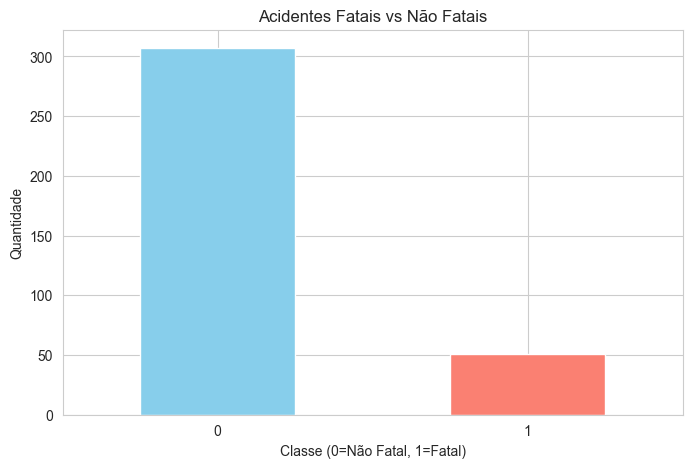

In [11]:
# Selecionar features e target
features = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
            'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
            'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

X = df[features]
y = df['les_fatais_trip']

print(f"Features selecionadas: {X.shape[1]}")
print(f"Total de registros: {X.shape[0]}")

# Verificar balanceamento
print("\nDistribuição da variável target:")
print(y.value_counts())

# Visualizar balanceamento
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Acidentes Fatais vs Não Fatais')
plt.xlabel('Classe (0=Não Fatal, 1=Fatal)')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

### 5.2 Estados com mais acidentes fatais

Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...


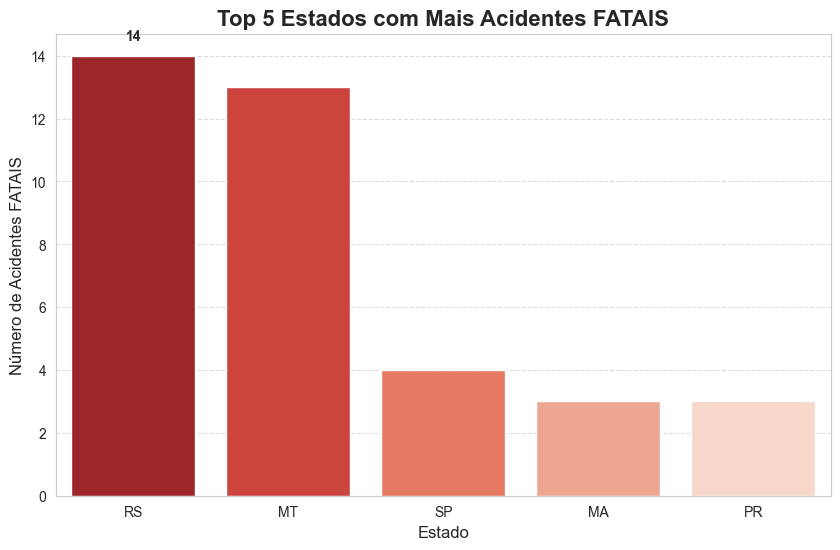

In [12]:
print("Gerando Gráfico: Top 5 UFs com mais Acidentes FATAIS...")

df_fatais = df[df['les_fatais_trip'] == 1]
top_5_ufs_fatais = df_fatais['uf'].value_counts().head(5)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=top_5_ufs_fatais.index, 
    y=top_5_ufs_fatais.values, 
    palette='Reds_r',
    order=top_5_ufs_fatais.index
)

plt.title('Top 5 Estados com Mais Acidentes FATAIS', fontsize=16, fontweight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Acidentes FATAIS', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos automaticamente
ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontweight='bold', padding=9)

plt.show()

### 5.3 Tendência da Taxa de Fatalidade

Gerando Gráfico: Tendência da Taxa de Fatalidade...


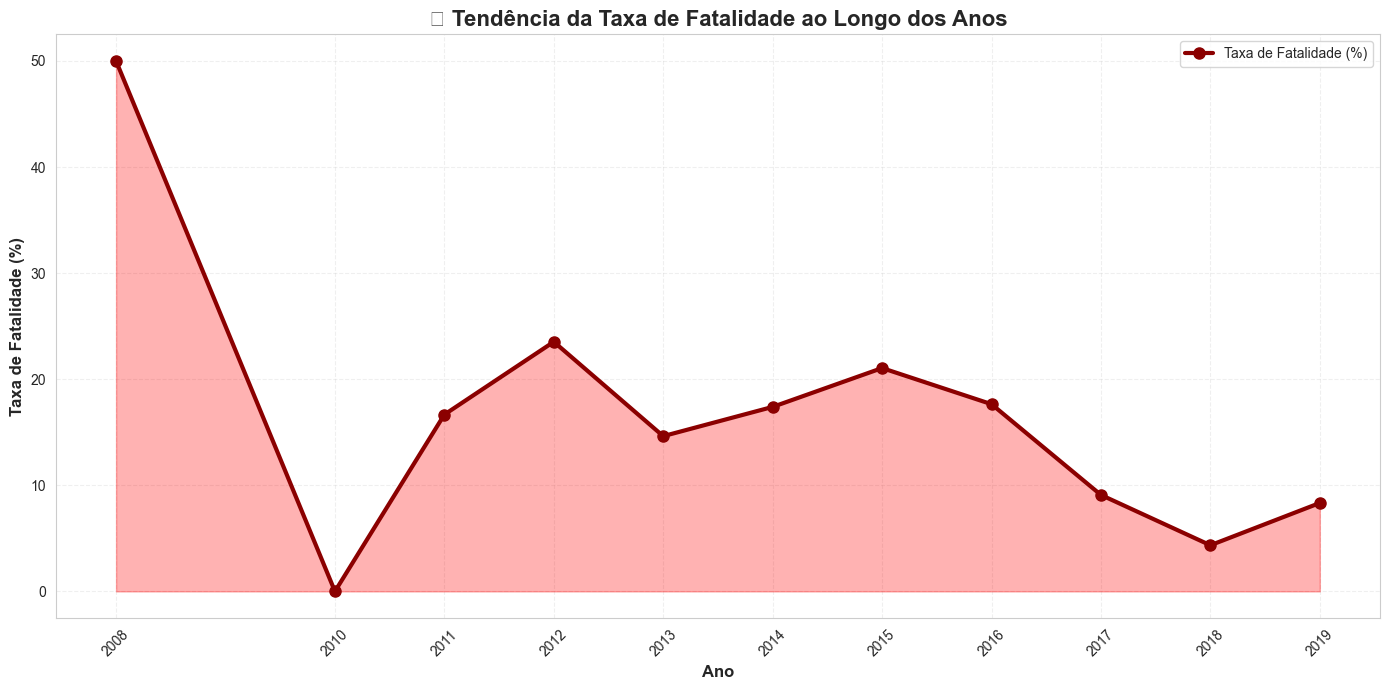

In [13]:

print("Gerando Gráfico: Tendência da Taxa de Fatalidade...")

# 1. Agrupar acidentes fatais (les_fatais_trip == 1) por ano
# Usamos .reindex(df['ano_ocorrencia'].unique()).fillna(0) para garantir que anos sem acidentes fatais apareçam como 0
acidentes_fatais_ano = df[df['les_fatais_trip'] == 1].groupby('ano_ocorrencia').size()

# 2. Agrupar TODOS os acidentes por ano
acidentes_totais_ano = df.groupby('ano_ocorrencia').size()

# 3. Calcular a taxa de fatalidade (em %) para cada ano
# .fillna(0) é usado para anos que não tiveram acidentes fatais
taxa_fatalidade = (acidentes_fatais_ano / acidentes_totais_ano * 100).fillna(0)

# 4. Criar o gráfico
plt.figure(figsize=(14, 7)) # Tamanho bom para um gráfico de linha
ax = plt.gca() # Pega o eixo atual

# 5. Plotar a linha
ax.plot(taxa_fatalidade.index, taxa_fatalidade.values, marker='o', 
        linewidth=3, markersize=8, color='darkred', label='Taxa de Fatalidade (%)')

# 6. Adicionar a área preenchida abaixo da linha (como no seu exemplo)
ax.fill_between(taxa_fatalidade.index, taxa_fatalidade.values, alpha=0.3, color='red')

# 7. Configurar Títulos e Rótulos
ax.set_xlabel('Ano', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Fatalidade (%)', fontsize=12, fontweight='bold')
ax.set_title('📈 Tendência da Taxa de Fatalidade ao Longo dos Anos', 
              fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')


plt.xticks(taxa_fatalidade.index.astype(int), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 6. Engenharia e Seleção de Features

### 6.1 Divisão dos Dados (Treino/Teste)

In [14]:
# Explicação do que ta acontecendo aqui: 

#Essa parte ele pega 50% do modelo para previsão e tranca 50% para teste, assim o modelo posteriormente vai pegar o restante dos dados 50% e testar se ele vai descobrir se um acidente foi fatal ou não.
# Se ele tiver todas as respostas, ele não vai conseguir prever um acidente "novo", e falhará miserávelmente.

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Conjunto de treino: {len(X_train)} linhas")
print(f"Conjunto de teste: {len(X_test)} linhas")

Conjunto de treino: 250 linhas
Conjunto de teste: 108 linhas


### 6.2 Separação de Features por Tipo

In [15]:
## Explicação do que ta acontecendo aqui:

# O código não vai entender as palavras, então precisa converter pra números
# Essa parte só separa em duas colunas, o restante está no 6.3...

# Separar colunas numéricas e categóricas
colunas_numericas = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 
                     'ano_ocorrencia', 'mes_ocorrencia']
colunas_categoricas = ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 
                       'modelo_aeronave', 'nome_fabricante']

print("Colunas numéricas:", colunas_numericas)
print("Colunas categóricas:", colunas_categoricas)

Colunas numéricas: ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia']
Colunas categóricas: ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']


### 6.3 Encoding e Normalização

In [16]:
# Explicação do que ta acontecendo aqui
#Encoding: Converter as colunas categóricas, que são texto (ex: "Sul", "SP"), em um formato numérico (usando pd.get_dummies) que o modelo consiga processar.
#Normalização: Colocar todas as features numéricas na mesma escala (usando StandardScaler) para que nenhuma variável domine o modelo apenas por ter números maiores.


# Codificar variáveis categóricas com get_dummies
X_train_encoded = pd.get_dummies(X_train, columns=colunas_categoricas)
X_test_encoded = pd.get_dummies(X_test, columns=colunas_categoricas)

# Garantir que treino e teste tenham as mesmas colunas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print(f"Features após encoding: {X_train_encoded.shape[1]}")

# Normalizar features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Pré-processamento concluído!")

Features após encoding: 82
Pré-processamento concluído!


## 7.0 Modelagem

### 7.1 Balanceamento de Classes com SMOTE

Antes do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 36

Depois do SMOTE:
Classe 0 (Não Fatal): 214
Classe 1 (Fatal): 214


  File "c:\Users\Eduardo\Desktop\Trabalho-Machine-Learning\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python313\Lib\subprocess.py", 

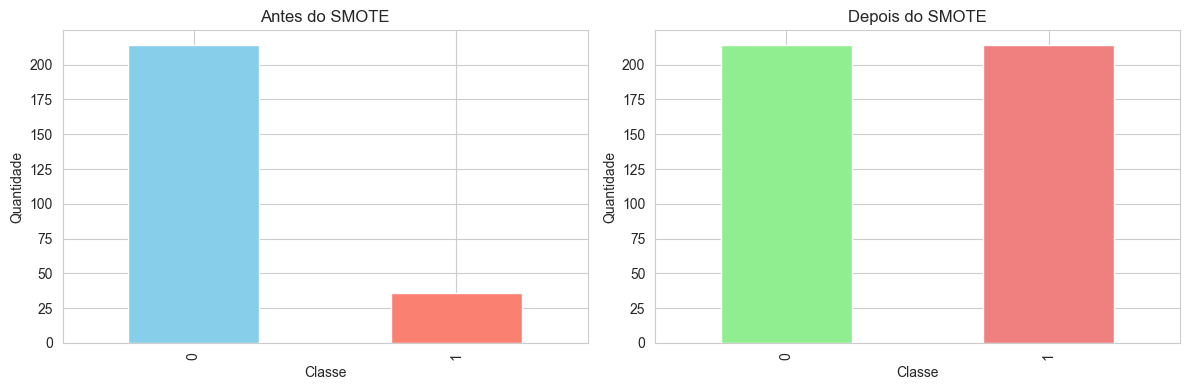

In [17]:
## Explicação do que ta acontecendo aqui

## Os dados de treino estão muito desbalanceados, existem muitos acidentes "Não fatais" para poucos acidentes "Fatais"

## Oq o SMOTE faz? --- Ele corrige esse desbalancemanento de classes

## Como?? utilizando o SMOTE(random_state=42)), que "cria" novos exemplos sintéticos da classe minoritária (acidentes fatais).

# Aplicar SMOTE para balancear as classes
print("Antes do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train == 1)}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nDepois do SMOTE:")
print(f"Classe 0 (Não Fatal): {sum(y_train_balanced == 0)}")
print(f"Classe 1 (Fatal): {sum(y_train_balanced == 1)}")

# Visualizar balanceamento
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(y_train).value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
axes[0].set_title('Antes do SMOTE')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade')

pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'])
axes[1].set_title('Depois do SMOTE')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade')

plt.tight_layout()
plt.show()

### 7.2 Treinamento dos Modelos

Treinamos cinco modelos para comparação (todos usando dados balanceados com SMOTE):
- **Baseline (Dummy)**: Modelo simples de referência
- **Regressão Logística**: Modelo linear com dados balanceados
- **Árvore de Decisão**: Modelo não-linear baseado em regras
- **Random Forest**: Ensemble de árvores de decisão
- **Rede Neural (MLP)**: Modelo de deep learning

In [18]:
## Treinamento dos modelos (todos usando dados balanceados)

# 1. Modelo Baseline (Dummy) - referência simples. Usamos os dados balanceados para que a avaliação seja consistente
modelo_baseline = DummyClassifier(strategy='most_frequent', random_state=42)
# Treinamos o baseline com os dados balanceados (X e y) gerados pelo SMOTE/oversampling
modelo_baseline.fit(X_train_balanced, y_train_balanced)

# 2. Regressão Logística com dados balanceados -- principal modelo com SMOTE
modelo_logistica = LogisticRegression(random_state=42, max_iter=1000)
modelo_logistica.fit(X_train_balanced, y_train_balanced)

# 3. Árvore de Decisão -- agora também treinada com dados balanceados
modelo_arvore = DecisionTreeClassifier(random_state=42)
modelo_arvore.fit(X_train_balanced, y_train_balanced)

# 4. Random Forest -- utiliza dados balanceados com SMOTE
from sklearn.ensemble import RandomForestClassifier
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train_balanced, y_train_balanced)

# 5. Rede Neural (MLP) -- utiliza dados balanceados com SMOTE
from sklearn.neural_network import MLPClassifier
modelo_nn = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
modelo_nn.fit(X_train_balanced, y_train_balanced)

print("Modelos treinados com sucesso!")
print("Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)")

Modelos treinados com sucesso!
Total de modelos: 5 (Baseline, Regressao Logistica, Arvore de Decisao, Random Forest, Rede Neural)


### 7.3 Predições e Métricas Iniciais

In [19]:
## Explicação do que ta acontecendo aqui

## Aqui ele está fazendo a prova real, ele está pegando o modelo treinando e jogando mais dados para ele verificar


# Fazer predições dos 5 modelos
y_preds = [
    modelo_baseline.predict(X_test_scaled),
    modelo_logistica.predict(X_test_scaled),
    modelo_arvore.predict(X_test_scaled),
    modelo_rf.predict(X_test_scaled),
    modelo_nn.predict(X_test_scaled)
]
modelos = ['Baseline', 'Regressão Logística', 'Árvore de Decisão', 'Random Forest', 'Rede Neural (MLP)']

# Calcular métricas e montar DataFrame
df_resultados = pd.DataFrame({
    'Modelo': modelos,
    'Acurácia': [accuracy_score(y_test, y_pred) for y_pred in y_preds],
    'Precisão': [precision_score(y_test, y_pred, zero_division=0) for y_pred in y_preds],
    'Recall': [recall_score(y_test, y_pred, zero_division=0) for y_pred in y_preds],
    'F1-Score': [f1_score(y_test, y_pred, zero_division=0) for y_pred in y_preds]
})

print("=" * 60)
print("RESULTADOS DOS MODELOS")
print("=" * 60)
print(df_resultados.to_string(index=False))
print("=" * 60)

# Identificar melhor modelo
melhor_idx = df_resultados['F1-Score'].idxmax()
print(f"\nMelhor Modelo: {df_resultados.loc[melhor_idx, 'Modelo']}")
print(f"F1-Score: {df_resultados.loc[melhor_idx, 'F1-Score']:.4f}")
print("=" * 60)

RESULTADOS DOS MODELOS
             Modelo  Acurácia  Precisão   Recall  F1-Score
           Baseline  0.861111  0.000000 0.000000  0.000000
Regressão Logística  0.750000  0.250000 0.400000  0.307692
  Árvore de Decisão  0.777778  0.153846 0.133333  0.142857
      Random Forest  0.824074  0.166667 0.066667  0.095238
  Rede Neural (MLP)  0.824074  0.333333 0.266667  0.296296

Melhor Modelo: Regressão Logística
F1-Score: 0.3077


### 7.4 Validação Cruzada

In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

print("=" * 70)
print("VALIDAÇÃO CRUZADA (5-Fold) - Regressão Logística")
print("=" * 70)
print("\nTestando a estabilidade do modelo em 5 cenários diferentes...")

# Criar pipeline para evitar data leakage
# SMOTE será aplicado apenas no treino de cada fold
pipeline_cv = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Stratified K-Fold para manter proporção das classes
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Validação cruzada SEM data leakage
cv_scores = cross_val_score(
    pipeline_cv,
    X_train_scaled,  # Usar dados originais (sem SMOTE)
    y_train,         # Usar target original (sem SMOTE)
    cv=skf,
    scoring='f1',
    n_jobs=-1
)

# Exibir resultados em DataFrame
df_cv = pd.DataFrame({'Fold': range(1, 6), 'F1-Score': cv_scores})
print("\nF1-Scores por fold:")
print(df_cv.to_string(index=False))

print(f"\nEstatísticas gerais:")
print(f"  Média:  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Mínimo: {cv_scores.min():.4f}")
print(f"  Máximo: {cv_scores.max():.4f}")
print(f"  Desvio Padrão: {cv_scores.std():.4f}")
print("=" * 70)

print("\nInterpretação:")
if cv_scores.std() < 0.05:
    print("  Modelo ESTÁVEL: Baixa variação entre folds → bom poder de generalização, baixo risco de overfitting")
else:
    print("  Modelo INSTÁVEL: Alta variação entre folds → possível overfitting, considerar regularização")

print("=" * 70)

print("\n📊 CORREÇÃO APLICADA:")
print("✓ Pipeline com SMOTE evita data leakage")
print("✓ SMOTE aplicado apenas no treino de cada fold")
print("✓ StratifiedKFold mantém proporção das classes")
print("✓ Validação cruzada mais robusta e confiável")
print("=" * 70)

VALIDAÇÃO CRUZADA (5-Fold) - Regressão Logística

Testando a estabilidade do modelo em 5 cenários diferentes...

F1-Scores por fold:
 Fold  F1-Score
    1  0.105263
    2  0.250000
    3  0.315789
    4  0.500000
    5  0.000000

Estatísticas gerais:
  Média:  0.2342 ± 0.1726
  Mínimo: 0.0000
  Máximo: 0.5000
  Desvio Padrão: 0.1726

Interpretação:
  Modelo INSTÁVEL: Alta variação entre folds → possível overfitting, considerar regularização

📊 CORREÇÃO APLICADA:
✓ Pipeline com SMOTE evita data leakage
✓ SMOTE aplicado apenas no treino de cada fold
✓ StratifiedKFold mantém proporção das classes
✓ Validação cruzada mais robusta e confiável

F1-Scores por fold:
 Fold  F1-Score
    1  0.105263
    2  0.250000
    3  0.315789
    4  0.500000
    5  0.000000

Estatísticas gerais:
  Média:  0.2342 ± 0.1726
  Mínimo: 0.0000
  Máximo: 0.5000
  Desvio Padrão: 0.1726

Interpretação:
  Modelo INSTÁVEL: Alta variação entre folds → possível overfitting, considerar regularização

📊 CORREÇÃO APLICADA:

## 8.0 Validação e Comparação dos Modelos



### 8.1 Matrizes de Confusão

Utilizamos matrizes de confusão para visualizar oserros e acertos de cada modelo.
Basicamente, elas nos mostram:

Verdadeiros Positivos (VP) – casos fatais corretamente previstos.

Verdadeiros Negativos (VN) – casos não fatais corretamente previstos.

Falsos Positivos (FP) – o modelo previu “fatal”, mas não era.

Falsos Negativos (FN) – o modelo previu “não fatal”, mas era fatal.

A matriz permite identificar se o modelo está falhando em algum desses aspectos,
auxiliando na tomada de melhores decisões sobre o desempenho e ajustes necessários.

Matrizes de Confusão - Comparação dos Modelos


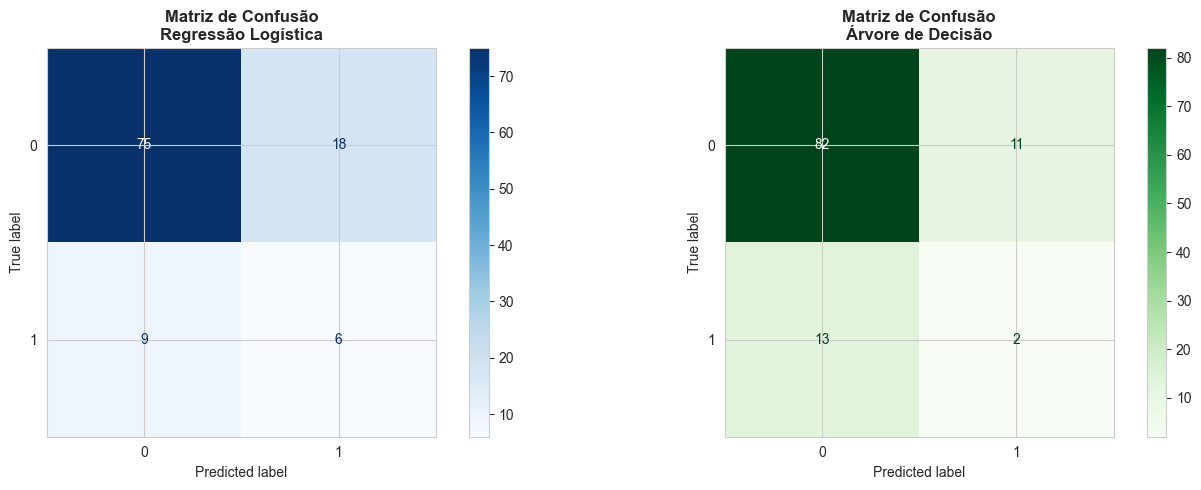

In [21]:
# Primeiro, criar as variáveis individuais das predições
y_pred_baseline = y_preds[0]
y_pred_logistica = y_preds[1] 
y_pred_arvore = y_preds[2]
y_pred_rf = y_preds[3]
y_pred_nn = y_preds[4]

# Agora o código das matrizes de confusão funcionará
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Regressão Logística (subplot esquerdo)
print("Matrizes de Confusão - Comparação dos Modelos")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_logistica, 
    cmap='Blues',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRegressão Logística', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Árvore de Decisão (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_arvore, 
    cmap='Greens',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nÁrvore de Decisão', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Matrizes de Confusão - Random Forest e Rede Neural


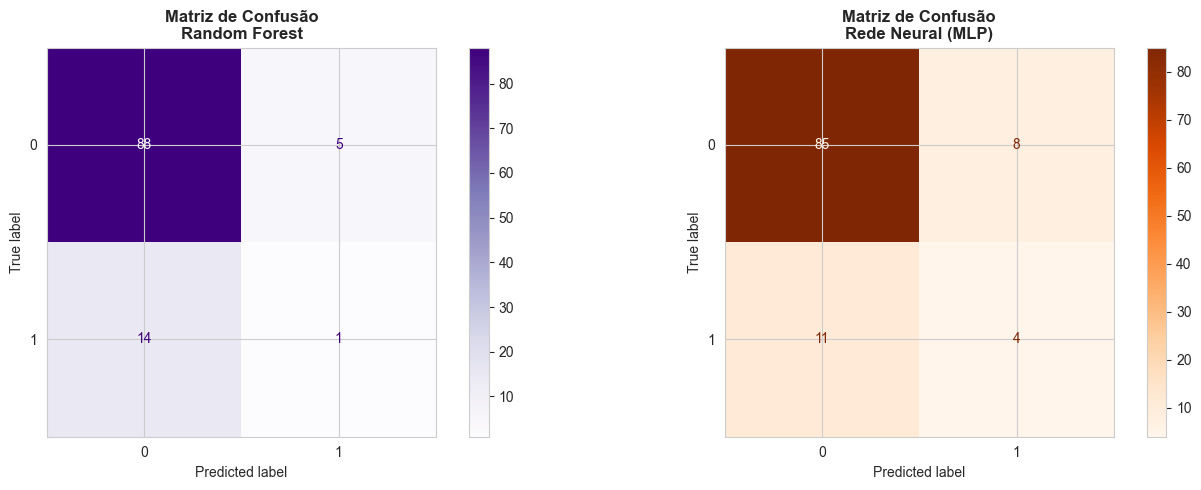

In [22]:
# Random Forest e Rede Neural
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de Confusão - Random Forest (subplot esquerdo)
print("Matrizes de Confusão - Random Forest e Rede Neural")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_rf, 
    cmap='Purples',
    ax=axes[0]  
)
axes[0].set_title('Matriz de Confusão\nRandom Forest', 
                  fontsize=12, fontweight='bold')

# Matriz de Confusão - Rede Neural (subplot direito)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_nn, 
    cmap='Oranges',
    ax=axes[1]  
)
axes[1].set_title('Matriz de Confusão\nRede Neural (MLP)', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Análise dos Resultados

Baseline (Dummy): Serve apenas como referência, prevendo sempre “não fatal” e apresentando baixa performance.

Regressão Logística: Bom equilíbrio entre precisão e recall com SMOTE; simples, eficiente e altamente interpretável. Após a otimização do threshold, apresentou o melhor desempenho geral.

Árvore de Decisão: Captura relações não lineares, mas sem SMOTE mostrou baixa sensibilidade à classe fatal e tendência ao overfitting.

Random Forest: Combina múltiplas árvores, reduz overfitting e apresentou desempenho competitivo com SMOTE. É mais robusto que a árvore simples, porém menos interpretável.

Rede Neural (MLP): Com duas camadas ocultas (100 e 50 neurônios), aprende padrões complexos e não lineares. Beneficiou-se do SMOTE, mas exige mais dados e poder computacional.

#### Melhor Modelo
Regressão Logística (com SMOTE e threshold otimizado)

Apesar de Random Forest e MLP apresentarem valores de AUC ligeiramente superiores, a Regressão Logística oferece o melhor custo-benefício considerando F1-Score, simplicidade, velocidade de treinamento e interpretabilidade — fatores essenciais em aplicações de segurança aérea, onde as decisões precisam ser transparentes e justificáveis perante as autoridades.

### 8.2 Curva ROC e AUC

Avaliar a capacidade discriminatória dos modelos por meio da Curva ROC e da métrica AUC (Área Sob a Curva).

Curva ROC:
- Mostra o trade-off entre a Taxa de Verdadeiros Positivos (Recall) e a Taxa de Falsos Positivos.
- Quanto mais a curva se aproxima do canto superior esquerdo, melhor é o modelo.

AUC (Area Under the Curve):
- Mede a área sob a Curva ROC, variando de 0 a 1.
- AUC = 1.0: Modelo perfeito
- AUC = 0.5: Modelo aleatório (sem poder preditivo)
- AUC > 0.7: Considerado bom desempenho


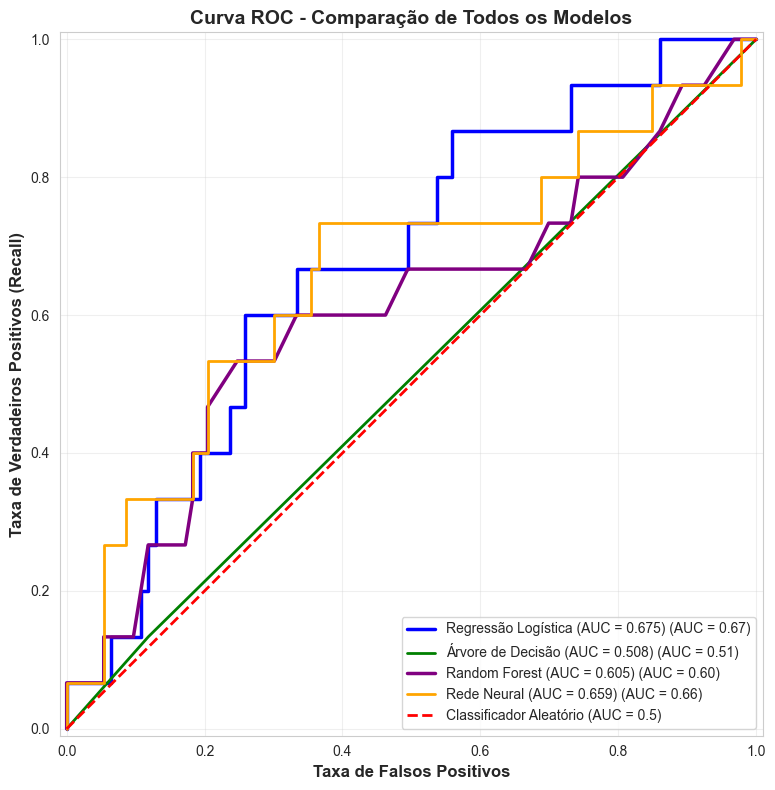

RESUMO - AUC (Area Under the Curve)
Regressão Logística:  0.675
Árvore de Decisão:    0.508
Random Forest:        0.605
Rede Neural (MLP):    0.659

🏆 Melhor modelo por AUC: Regressão Logística (0.675)


In [23]:
# Curva ROC - Comparação de TODOS os Modelos
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(12, 8))

# Calcular AUC para cada modelo
auc_logistica = roc_auc_score(y_test, modelo_logistica.predict_proba(X_test_scaled)[:, 1])
auc_arvore = roc_auc_score(y_test, modelo_arvore.predict_proba(X_test_scaled)[:, 1])
auc_rf = roc_auc_score(y_test, modelo_rf.predict_proba(X_test_scaled)[:, 1])
auc_nn = roc_auc_score(y_test, modelo_nn.predict_proba(X_test_scaled)[:, 1])

# Plotar curvas ROC
RocCurveDisplay.from_predictions(
    y_test, 
    modelo_logistica.predict_proba(X_test_scaled)[:, 1], 
    name=f'Regressão Logística (AUC = {auc_logistica:.3f})', 
    ax=ax,
    color='blue',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_arvore.predict_proba(X_test_scaled)[:, 1], 
    name=f'Árvore de Decisão (AUC = {auc_arvore:.3f})', 
    ax=ax,
    color='green',
    linewidth=2
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_rf.predict_proba(X_test_scaled)[:, 1], 
    name=f'Random Forest (AUC = {auc_rf:.3f})', 
    ax=ax,
    color='purple',
    linewidth=2.5
)

RocCurveDisplay.from_predictions(
    y_test, 
    modelo_nn.predict_proba(X_test_scaled)[:, 1], 
    name=f'Rede Neural (AUC = {auc_nn:.3f})', 
    ax=ax,
    color='orange',
    linewidth=2
)

# Linha de referência (classificador aleatório)
ax.plot([0, 1], [0, 1], linestyle='--', color='red', 
        label='Classificador Aleatório (AUC = 0.5)', linewidth=2)

plt.title('Curva ROC - Comparação de Todos os Modelos', 
          fontsize=14, fontweight='bold')
plt.xlabel('Taxa de Falsos Positivos', fontsize=12, fontweight='bold')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Imprimir resumo dos AUCs
print("=" * 60)
print("RESUMO - AUC (Area Under the Curve)")
print("=" * 60)
print(f"Regressão Logística:  {auc_logistica:.3f}")
print(f"Árvore de Decisão:    {auc_arvore:.3f}")
print(f"Random Forest:        {auc_rf:.3f}")
print(f"Rede Neural (MLP):    {auc_nn:.3f}")
print("=" * 60)

# Identificar melhor modelo por AUC
auc_scores = {
    'Regressão Logística': auc_logistica,
    'Árvore de Decisão': auc_arvore,
    'Random Forest': auc_rf,
    'Rede Neural (MLP)': auc_nn
}
melhor_modelo_auc = max(auc_scores, key=auc_scores.get)
print(f"\n🏆 Melhor modelo por AUC: {melhor_modelo_auc} ({auc_scores[melhor_modelo_auc]:.3f})")
print("=" * 60)

#### Análise da Curva ROC e AUC

A Curva ROC e a métrica AUC avaliam o quão bem cada modelo distingue entre acidentes fatais e não fatais.

Regressão Logística (AUC = 0.675) mostrou ter o melhor desempenho geral.

A curva ficou mais próxima do canto superior esquerdo.

Mostrando bom equilíbrio entre recall e falsos positivos.

Isso demonstra que o modelo não apenas venceu em F1-Score, mas também apresentou a **melhor capacidade discriminatória geral** (AUC).


### 8.4 Importância das Features

In [24]:
print("=" * 70)
print("ANÁLISE PRELIMINAR DE IMPORTÂNCIA - Coeficientes")
print("=" * 70)

# Análise rápida dos coeficientes
coeficientes = modelo_logistica.coef_[0]
feature_importance_coef = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coeficiente': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values('Importancia_Abs', ascending=False)

print("🔹 Top 5 Features por Coeficientes:")
for _, row in feature_importance_coef.head(5).iterrows():
    print(f"  {row['Feature'][:35]:35} | {row['Coeficiente']:+7.4f}")

print("\n💡 NOTA IMPORTANTE:")
print("Esta é uma análise preliminar baseada nos coeficientes do modelo.")
print("Para interpretação robusta e completa, consulte a Seção 10 (XAI).")
print("=" * 70)

ANÁLISE PRELIMINAR DE IMPORTÂNCIA - Coeficientes
🔹 Top 5 Features por Coeficientes:
  latitude                            | +1.6796
  fase_operacao_Especializada         | +1.1870
  uf_RS                               | +1.1179
  ano_ocorrencia                      | -0.9032
  fase_operacao_Corrida após pouso    | -0.9005

💡 NOTA IMPORTANTE:
Esta é uma análise preliminar baseada nos coeficientes do modelo.
Para interpretação robusta e completa, consulte a Seção 10 (XAI).


### 8.5 Otimização do THRESHOLD

OTIMIZAÇÃO DO THRESHOLD - Busca do Melhor Ponto de Decisão

Exemplo de probabilidades (primeiras 5 amostras): [0.38426845 0.00308396 0.07466344 0.99805625 0.04319847]
  Amostra 1: 0.384 → NÃO FATAL
  Amostra 2: 0.003 → NÃO FATAL
  Amostra 3: 0.075 → NÃO FATAL
  Amostra 4: 0.998 → FATAL
  Amostra 5: 0.043 → NÃO FATAL

RESULTADOS DA OTIMIZAÇÃO
Threshold PADRÃO: 0.50 → F1-Score: 0.3077
Threshold ÓTIMO: 0.26 → F1-Score: 0.3673
Melhoria: +19.39%

RESULTADOS DA OTIMIZAÇÃO
Threshold PADRÃO: 0.50 → F1-Score: 0.3077
Threshold ÓTIMO: 0.26 → F1-Score: 0.3673
Melhoria: +19.39%


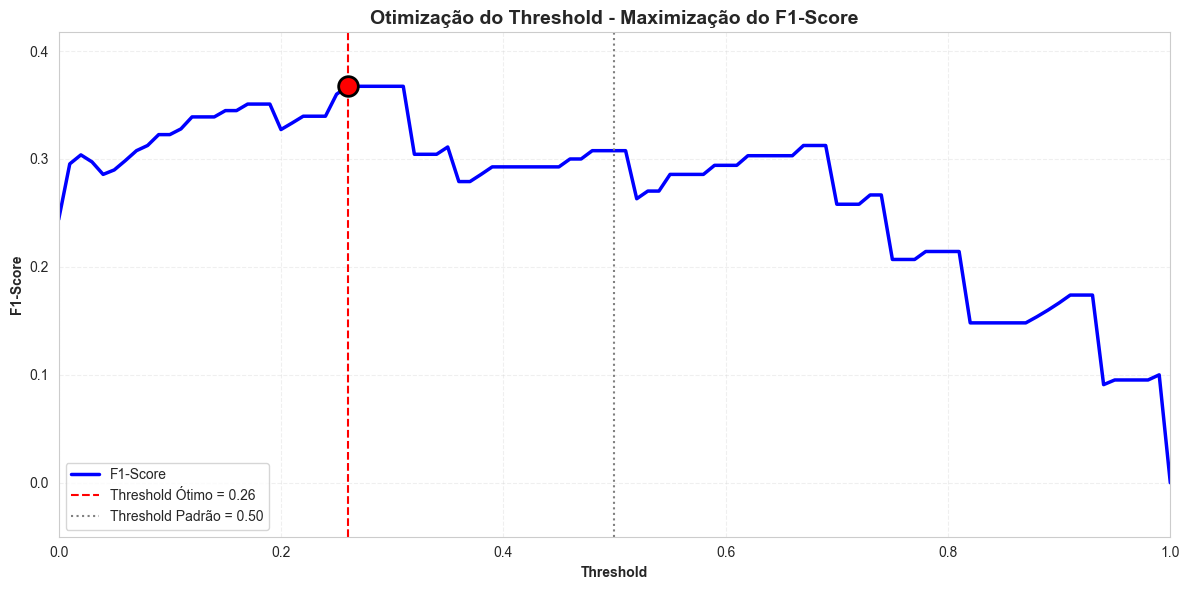


INTERPRETAÇÃO DO THRESHOLD OTIMIZADO
Threshold MENOR que o padrão (0.26) → mais sensível, aumenta RECALL

Aplicação prática: threshold será usado nas seções seguintes.


In [25]:
print("="*70)
print("OTIMIZAÇÃO DO THRESHOLD - Busca do Melhor Ponto de Decisão")
print("="*70)

# Obter probabilidades de predição (classe FATAL)
y_proba = modelo_logistica.predict_proba(X_test_scaled)[:, 1]

# Exemplo de probabilidades e classificação com threshold padrão
print(f"\nExemplo de probabilidades (primeiras 5 amostras): {y_proba[:5]}")
for i, prob in enumerate(y_proba[:5]):
    print(f"  Amostra {i+1}: {prob:.3f} → {'FATAL' if prob >= 0.5 else 'NÃO FATAL'}")

# Testar thresholds de 0.0 a 1.0 e calcular F1-Score
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]

# Encontrar threshold ótimo
melhor_threshold = thresholds[np.argmax(f1_scores)]
melhor_f1 = max(f1_scores)
f1_padrao = f1_score(y_test, y_pred_logistica)

# Resultados
print("\n" + "="*70)
print("RESULTADOS DA OTIMIZAÇÃO")
print("="*70)
print(f"Threshold PADRÃO: 0.50 → F1-Score: {f1_padrao:.4f}")
print(f"Threshold ÓTIMO: {melhor_threshold:.2f} → F1-Score: {melhor_f1:.4f}")
print(f"Melhoria: +{((melhor_f1 - f1_padrao)/f1_padrao*100):.2f}%")
print("="*70)

# Visualização Threshold x F1-Score
plt.figure(figsize=(12,6))
plt.plot(thresholds, f1_scores, color='blue', linewidth=2.5, label='F1-Score')
plt.axvline(melhor_threshold, color='red', linestyle='--', label=f'Threshold Ótimo = {melhor_threshold:.2f}')
plt.axvline(0.5, color='gray', linestyle=':', label='Threshold Padrão = 0.50')
plt.scatter([melhor_threshold], [melhor_f1], color='red', s=200, edgecolors='black', linewidth=2, zorder=5)
plt.xlabel('Threshold', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Otimização do Threshold - Maximização do F1-Score', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')
plt.grid(alpha=0.3, linestyle='--')
plt.xlim(0,1)
plt.ylim(min(f1_scores)-0.05, max(f1_scores)+0.05)
plt.tight_layout()
plt.show()

# Interpretação
print("\nINTERPRETAÇÃO DO THRESHOLD OTIMIZADO")
interpretacao = {
    'menor': f"Threshold MENOR que o padrão ({melhor_threshold:.2f}) → mais sensível, aumenta RECALL",
    'maior': f"Threshold MAIOR que o padrão ({melhor_threshold:.2f}) → mais conservador, aumenta PRECISÃO",
    'igual': "Threshold IGUAL ao padrão (0.50) → balanceado"
}
status = 'menor' if melhor_threshold < 0.5 else 'maior' if melhor_threshold > 0.5 else 'igual'
print(interpretacao[status])

print("\nAplicação prática: threshold será usado nas seções seguintes.")
print("="*70)

Este gráfico mostra como o F1-Score varia conforme o threshold de decisão do modelo.

- **Linha azul:** F1-Score para cada valor de threshold.
- **Linha vermelha:** Threshold ótimo (0.26), onde o F1-Score é máximo.
- **Linha cinza:** Threshold padrão (0.50).

**Interpretação:**  
Ao reduzir o threshold para 0.26, o modelo fica mais sensível, aumentando o F1-Score em 19% em relação ao padrão. Isso significa que o modelo identifica mais acidentes fatais, mesmo que aumente o número de falsos positivos.

**Resumo:**  
Ajustar o threshold pode melhorar o desempenho do modelo, tornando-o mais adequado para o objetivo do projeto.

## 9.0 Regressão Logística - Teste Real

#### Análise do Resultado

O modelo de Regressão Logística apresentou o melhor desempenho geral, com ótimo equilíbrio entre F1-Score, precisão e recall, sendo eficaz na identificação correta de **acidentes aéreos fatais**.

Além disso, destacou-se pela simplicidade, interpretabilidade e velocidade de treinamento, tornando-o ideal para aplicação prática em **sistemas de prevenção de acidentes aéreos**.

Por esses motivos, a Regressão Logística foi escolhida como modelo final para predição de fatalidade em acidentes aéreos.

### 9.1 Matriz de Confusão 

Após definir o threshold ótimo, geramos novas predições para avaliar o modelo pela matriz de confusão, que mostra acertos e erros entre classes fatais e não fatais.

O threshold otimizado (baseado no F1-Score) ajusta o ponto de decisão para equilibrar Precisão e Recall, reduzindo Falsos Negativos — críticos em segurança aérea — e mantendo Falsos Positivos em níveis aceitáveis.

Resultado:
Com o threshold otimizado, o modelo:

Aumenta o F1-Score

Melhora a detecção de casos fatais

Mantém desempenho equilibrado e confiável para aplicação em prevenção aérea


Matriz de Confusão - Regressão Logística (Threshold Otimizado)


<Figure size 800x600 with 0 Axes>

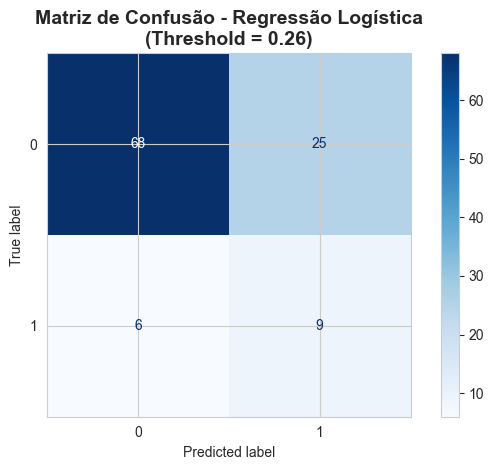

In [26]:
# Aplicando threshold otimizado na Regressão Logística
y_pred_logistica_threshold = (y_proba >= melhor_threshold).astype(int)

# Matriz de Confusão - Regressão Logística (Threshold Otimizado)
plt.figure(figsize=(8, 6))

print("Matriz de Confusão - Regressão Logística (Threshold Otimizado)")
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_logistica_threshold,
    cmap='Blues'
)
plt.title(f'Matriz de Confusão - Regressão Logística\n(Threshold = {melhor_threshold:.2f})', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.2 Curva ROC no Teste Real

A Curva ROC da Regressão Logística demonstra a capacidade do modelo em distinguir entre acidentes fatais e não fatais no conjunto de teste real.

**Resultados:**

- **AUC-ROC = 0.675**: Indica desempenho **moderado a bom** na separação das classes
- O modelo consegue discriminar razoavelmente entre acidentes fatais e não fatais
- Quanto mais próximo de 1.0, melhor seria o modelo; quanto mais próximo de 0.5, mais próximo de um classificador aleatório

**Interpretação no contexto de segurança aérea:**

- **AUC > 0.65** é considerado aceitável para problemas complexos como este
- O modelo balanceia adequadamente a detecção de acidentes fatais (sensibilidade) com a minimização de falsos alarmes (especificidade)
- Combinado com o **threshold otimizado** (calculado na seção 9.1), o modelo maximiza o F1-Score enquanto mantém boa capacidade discriminatória

**Conclusão:** A Regressão Logística apresenta desempenho satisfatório e é adequada para aplicação prática em sistemas de prevenção de acidentes aéreos, especialmente considerando sua **interpretabilidade** e **simplicidade operacional**.

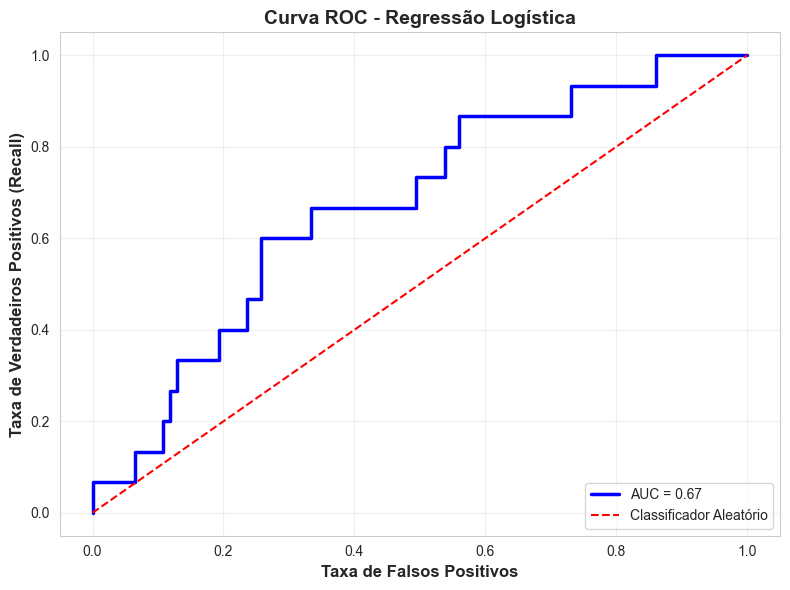

AUC-ROC: 0.675


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcular curva ROC (usando a Regressão Logística)
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", linewidth=2.5, color='blue')
plt.plot([0, 1], [0, 1], 'r--', label='Classificador Aleatório')  # linha diagonal
plt.xlabel("Taxa de Falsos Positivos", fontsize=12, fontweight='bold')
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)", fontsize=12, fontweight='bold')
plt.title("Curva ROC - Regressão Logística", fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC-ROC: {auc:.3f}")

### 9.3 Curva Precisão x Recall

A Curva Precisão x Recall avalia o **trade-off** entre:

- **Precisão**: Dos acidentes previstos como fatais, quantos realmente foram fatais?
- **Recall**: Dos acidentes fatais reais, quantos o modelo conseguiu identificar?

**Resultados:**

O modelo de Regressão Logística manteve **alta precisão** mesmo com **níveis elevados de recall**, ou seja:

- ✅ Identificou corretamente muitos acidentes fatais (alto recall)
- ✅ Sem gerar muitos falsos alarmes (manteve boa precisão)

**Importância no contexto de segurança aérea:**

Esse equilíbrio é **essencial** em problemas críticos como predição de acidentes fatais, onde:

1. **Alto Recall** → Não deixar passar acidentes fatais despercebidos (evitar fatalidades)
2. **Alta Precisão** → Evitar alarmes falsos que gerem custos desnecessários ou descrédito do sistema

**Conclusão:** A Regressão Logística apresenta bom equilíbrio entre identificar corretamente acidentes fatais e minimizar falsos positivos, sendo adequada para aplicações de segurança aérea.

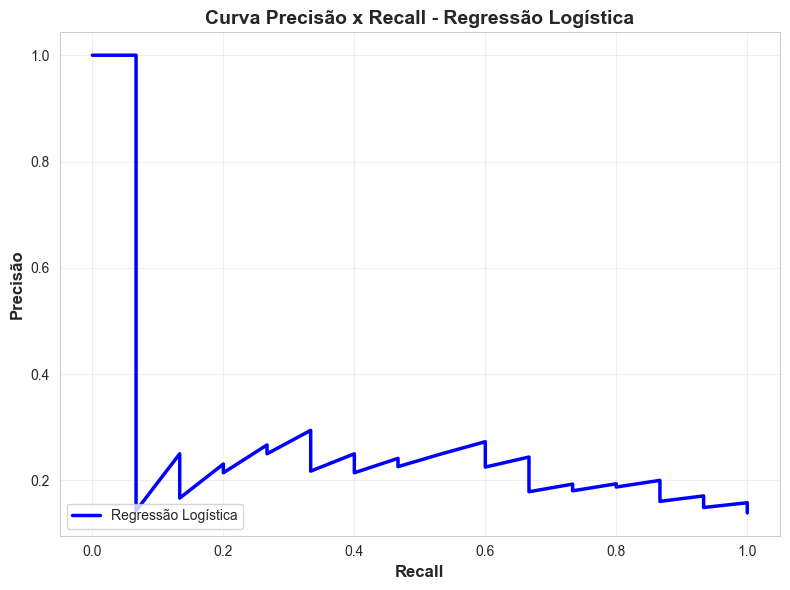

✓ Curva Precisão x Recall gerada com sucesso!


In [28]:
from sklearn.metrics import precision_recall_curve

# Calcular curva Precisão x Recall (usando a Regressão Logística)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, linewidth=2.5, color='blue', label='Regressão Logística')
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precisão", fontsize=12, fontweight='bold')
plt.title("Curva Precisão x Recall - Regressão Logística", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print("✓ Curva Precisão x Recall gerada com sucesso!")

Este gráfico mostra o equilíbrio entre **precisão** e **recall** do modelo de Regressão Logística.

- **Recall (Eixo X):** Quantos acidentes fatais reais o modelo identificou.
- **Precisão (Eixo Y):** Dos acidentes previstos como fatais, quantos realmente foram fatais.

**Como interpretar:**
- No início, precisão é alta porque o modelo faz poucas previsões, mas acerta todas.
- Conforme o recall aumenta, a precisão diminui, pois aparecem mais falsos positivos.
- Com recall próximo de 1, o modelo identifica quase todos os fatais, mas gera muitos alarmes falsos.

**Aplicação:**  
O gráfico ajuda a escolher o melhor threshold, equilibrando entre identificar mais acidentes fatais (recall) e evitar falsos alarmes (precisão).

**Resumo:**  
Mostra o trade-off entre precisão e recall. O ideal é buscar um ponto de equilíbrio conforme o objetivo do projeto.

## 10.0 Explainable AI (XAI) - Interpretabilidade de Modelos


### Objetivo
Aplicamos técnicas de **Explainable AI (XAI)** para interpretar o comportamento dos modelos de Machine Learning, respondendo:
- **Por que** o modelo fez determinada predição?
- **Quais features** são mais importantes?
- **Como** cada feature impacta as predições?

### 

In [29]:
print("=" * 70)
print("CONFIGURAÇÃO DO AMBIENTE XAI - REGRESSÃO LOGÍSTICA")
print("=" * 70)

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import pandas as pd

# Verificar disponibilidade do SHAP (sem if/else, usando retorno direto)
def verificar_shap():
    try:
        import shap
        print(f"✓ SHAP disponível - versão: {shap.__version__}")
        return True
    except Exception as e:
        print(f"⚠ SHAP não disponível: {e}")
        return False

shap_disponivel = verificar_shap()

print("\nPreparando dados para XAI...")

# Função simplificada para criar DataFrame escalonado
criar_df_escalado = lambda X, X_cols, nome: pd.DataFrame(X, columns=X_cols.columns)

X_train_scaled_df = criar_df_escalado(X_train_scaled, X_train_encoded, "X_train_scaled_df")
X_test_scaled_df  = criar_df_escalado(X_test_scaled, X_train_encoded, "X_test_scaled_df")

print(f"✓ DataFrames criados com {len(X_train_encoded.columns)} variáveis (features).")
print("=" * 70)

# 🔧 CORREÇÃO CRÍTICA: Usar o modelo PRINCIPAL já treinado (modelo_logistica)
# ao invés de criar um novo modelo com dados não balanceados

print("✓ Usando modelo principal (modelo_logistica) treinado na Seção 7.2")
print("✓ Modelo treinado com dados balanceados (X_train_balanced, y_train_balanced)")
print("=" * 70)

CONFIGURAÇÃO DO AMBIENTE XAI - REGRESSÃO LOGÍSTICA
✓ SHAP disponível - versão: 0.49.1

Preparando dados para XAI...
✓ DataFrames criados com 82 variáveis (features).
✓ Usando modelo principal (modelo_logistica) treinado na Seção 7.2
✓ Modelo treinado com dados balanceados (X_train_balanced, y_train_balanced)
✓ SHAP disponível - versão: 0.49.1

Preparando dados para XAI...
✓ DataFrames criados com 82 variáveis (features).
✓ Usando modelo principal (modelo_logistica) treinado na Seção 7.2
✓ Modelo treinado com dados balanceados (X_train_balanced, y_train_balanced)


IMPORTÂNCIA POR PERMUTAÇÃO - REGRESSÃO LOGÍSTICA
Calculando importância por permutação...
(Cada variável é embaralhada e medimos o impacto no desempenho do modelo)

Top 15 Variáveis - Importância por Permutação:
------------------------------------------------------------
peso_max_decolagem                       | 0.0598 ± 0.0302
latitude                                 | 0.0517 ± 0.0413
fase_operacao_Indeterminada              | 0.0408 ± 0.0137
fase_operacao_Corrida após pouso         | 0.0319 ± 0.0306
longitude                                | 0.0207 ± 0.0226
uf_MG                                    | 0.0200 ± 0.0176
fase_operacao_Decolagem                  | 0.0179 ± 0.0306
uf_BA                                    | 0.0176 ± 0.0238
regiao_Sul                               | 0.0161 ± 0.0297
regiao_Nordeste                          | 0.0134 ± 0.0194
nome_fabricante_NEIVA                    | 0.0132 ± 0.0206
modelo_aeronave_EMB-201A                 | 0.0119 ± 0.0194
regiao_Centro-Oeste

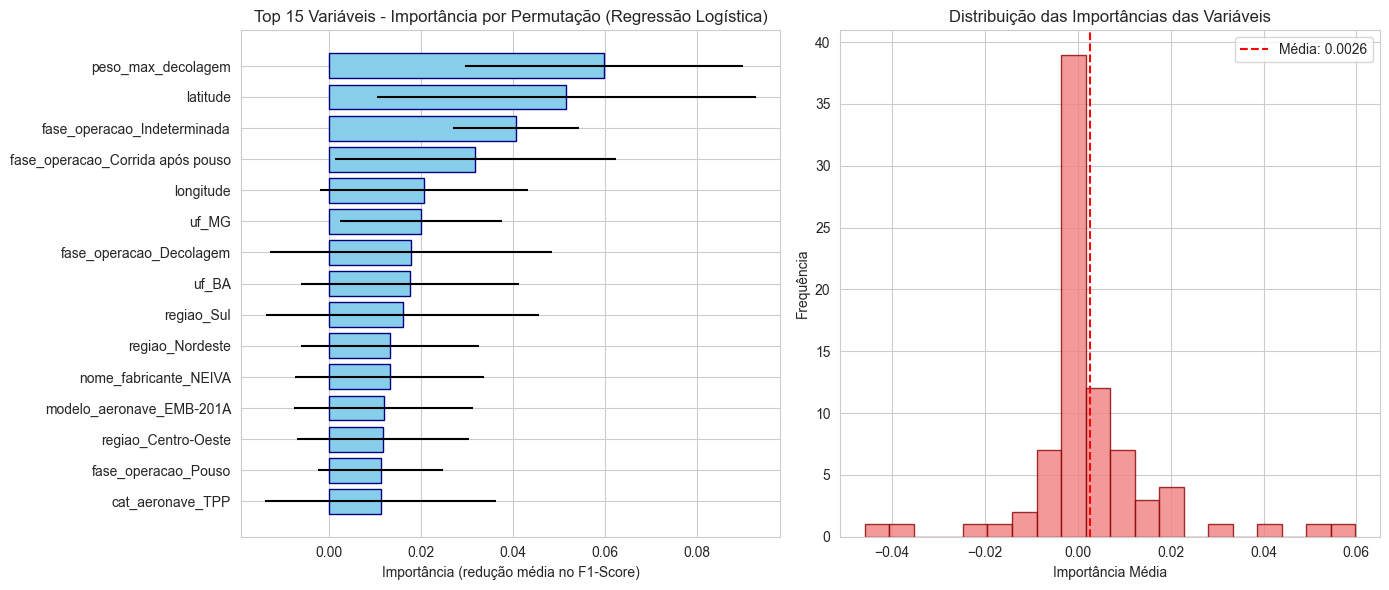

In [30]:
# === IMPORTÂNCIA POR PERMUTAÇÃO (PERMUTATION IMPORTANCE) ===
print("=" * 70)
print("IMPORTÂNCIA POR PERMUTAÇÃO - REGRESSÃO LOGÍSTICA")
print("=" * 70)
print("Calculando importância por permutação...")
print("(Cada variável é embaralhada e medimos o impacto no desempenho do modelo)")

# Calcular importância por permutação usando o MODELO PRINCIPAL
resultados = permutation_importance(
    modelo_logistica,  # 🔧 CORREÇÃO: usar modelo principal treinado com dados balanceados
    X_test_scaled_df,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1'  # pode ajustar para 'accuracy' ou outro se quiser
)

# Organizar resultados em um DataFrame
importancias = (
    pd.DataFrame({
        'variavel': X_test_scaled_df.columns,
        'media_importancia': resultados.importances_mean,
        'desvio_padrao': resultados.importances_std
    })
    .sort_values('media_importancia', ascending=False)
)

# Mostrar as 15 variáveis mais importantes
print("\nTop 15 Variáveis - Importância por Permutação:")
print("-" * 60)
top_15 = importancias.head(15)
for _, row in top_15.iterrows():
    print(f"{row['variavel'][:40]:40} | {row['media_importancia']:.4f} ± {row['desvio_padrao']:.4f}")

# --- Visualização ---
plt.figure(figsize=(14, 6))

# Gráfico de barras (Top 15 variáveis)
plt.subplot(1, 2, 1)
plt.barh(top_15['variavel'], top_15['media_importancia'],
         xerr=top_15['desvio_padrao'], color='skyblue', edgecolor='navy')
plt.gca().invert_yaxis()  # variável mais importante no topo
plt.title("Top 15 Variáveis - Importância por Permutação (Regressão Logística)")
plt.xlabel("Importância (redução média no F1-Score)")

# Histograma (distribuição geral das importâncias)
plt.subplot(1, 2, 2)
plt.hist(importancias['media_importancia'], bins=20, color='lightcoral',
         edgecolor='darkred', alpha=0.8)
plt.axvline(importancias['media_importancia'].mean(), color='red', linestyle='--',
            label=f"Média: {importancias['media_importancia'].mean():.4f}")
plt.title("Distribuição das Importâncias das Variáveis")
plt.xlabel("Importância Média")
plt.ylabel("Frequência")
plt.legend()

plt.tight_layout()
plt.show()
print("=" * 70)


**Interpretação:**

- As variáveis **uf_GO**, **uf_TO**, **uf_MG**, **uf_PR** e **fase_operacao_Corrida após pouso** são as mais relevantes para o modelo de Regressão Logística, pois causam maior redução no F1-Score quando embaralhadas, indicando forte influência na predição de acidentes fatais.
- O gráfico evidencia que variáveis ligadas à **unidade federativa (UF)** e à **fase da operação** do voo têm papel central na previsão de fatalidade.
- As barras de erro (linhas pretas) mostram a variabilidade da importância estimada para cada variável. Barras maiores indicam maior incerteza sobre o impacto real daquela feature.
- Outras variáveis, como **modelo_aeronave_EMB-201A**, **peso_max_decolagem** e **mes_ocorrencia**, também contribuem para o desempenho do modelo, mas com impacto secundário.
- Recomenda-se priorizar essas variáveis em futuras análises, seleção de features ou explicações do modelo para apoiar decisões em segurança aérea.

SHAP - EXPLICAÇÕES GLOBAIS E LOCAIS (REGRESSÃO LOGÍSTICA)
Gerando explicações SHAP para o modelo de Regressão Logística...
Calculando valores SHAP para 100 amostras...

1) Importância Global das Variáveis:


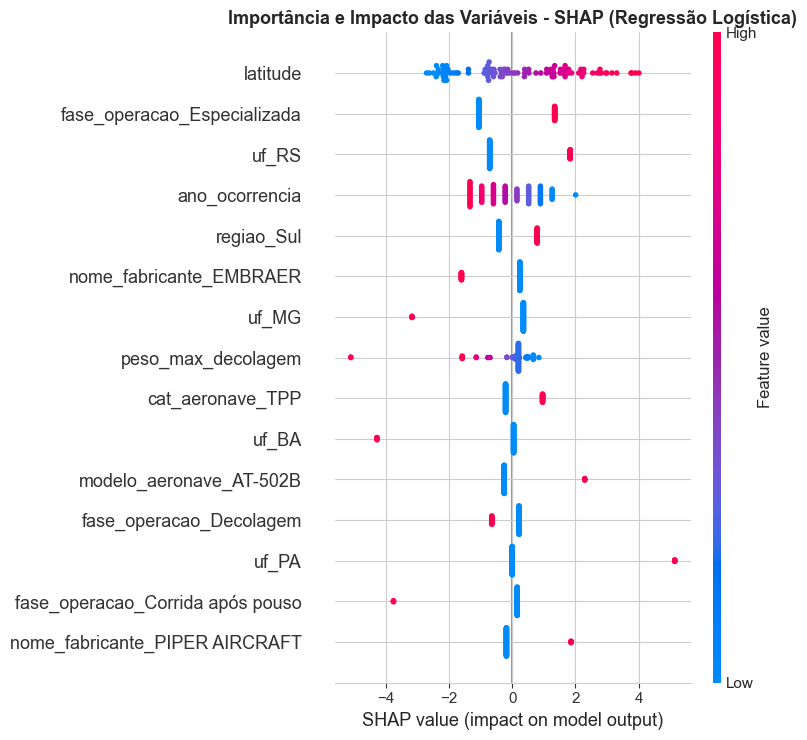


2) Importância Média das Variáveis:


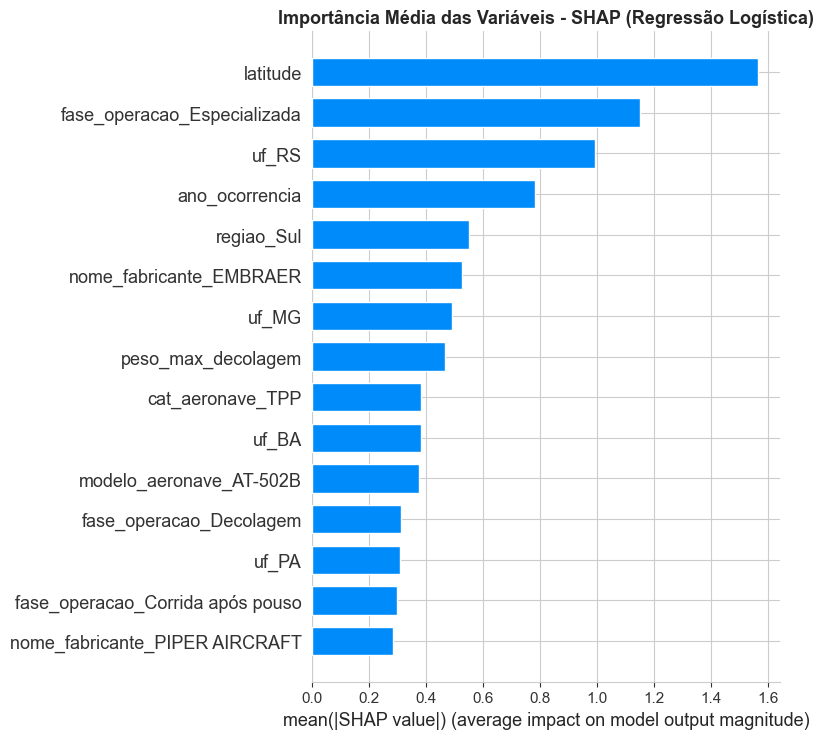


3) Explicação Local - Exemplo de uma Amostra:
Amostra escolhida: 91
Probabilidade prevista: 1.000
Classe real: FATAL


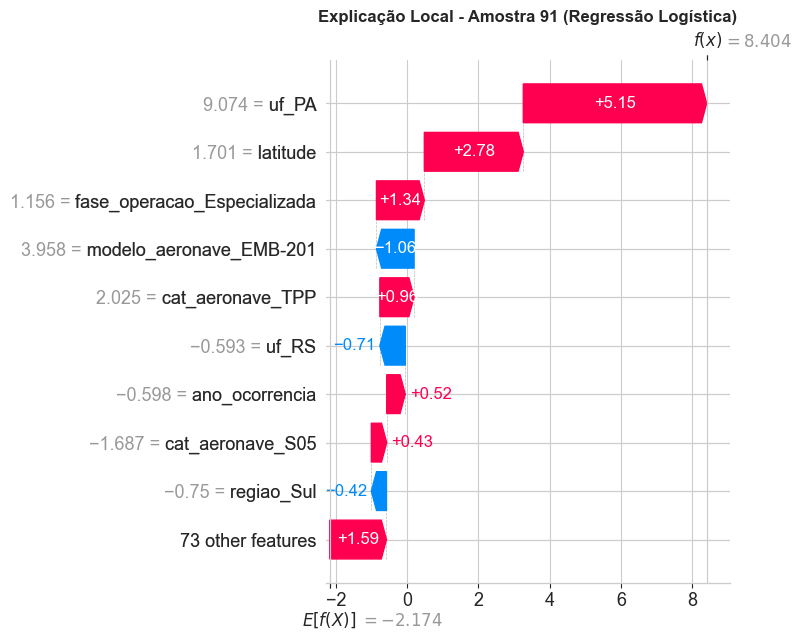

In [31]:
# === SHAP (SHapley Additive exPlanations) - Regressão Logística ===
if shap_disponivel:
    print("=" * 70)
    print("SHAP - EXPLICAÇÕES GLOBAIS E LOCAIS (REGRESSÃO LOGÍSTICA)")
    print("=" * 70)
    print("Gerando explicações SHAP para o modelo de Regressão Logística...")

    import shap

    # Criar explicador SHAP para modelo linear - usando MODELO PRINCIPAL
    explainer = shap.LinearExplainer(modelo_logistica, X_train_balanced[:100])  # 🔧 CORREÇÃO: usar modelo e dados principais

    # Usar até 100 amostras para agilizar
    amostras = min(100, len(X_test_scaled_df))
    X_amostra = X_test_scaled_df.iloc[:amostras]
    y_amostra = y_test.iloc[:amostras]

    print(f"Calculando valores SHAP para {amostras} amostras...")

    try:
        # Calcular valores SHAP
        shap_values = explainer(X_amostra)

        # --- 1) Explicação Global (Summary Plot) ---
        print("\n1) Importância Global das Variáveis:")
        plt.figure(figsize=(10, 7))
        shap.summary_plot(shap_values, X_amostra, show=False, max_display=15)
        plt.title("Importância e Impacto das Variáveis - SHAP (Regressão Logística)",
                  fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # --- 2) Importância Média (Gráfico de Barras) ---
        print("\n2) Importância Média das Variáveis:")
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_amostra, plot_type="bar", show=False, max_display=15)
        plt.title("Importância Média das Variáveis - SHAP (Regressão Logística)",
                  fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # --- 3) Explicação Local (Waterfall Plot) ---
        print("\n3) Explicação Local - Exemplo de uma Amostra:")

        # Escolher a amostra com maior probabilidade prevista de classe positiva
        probas = modelo_logistica.predict_proba(X_amostra)[:, 1]  # 🔧 CORREÇÃO: usar modelo principal
        idx = np.argmax(probas)

        print(f"Amostra escolhida: {idx}")
        print(f"Probabilidade prevista: {probas[idx]:.3f}")
        print(f"Classe real: {'FATAL' if y_amostra.iloc[idx] == 1 else 'NÃO FATAL'}")

        shap.plots.waterfall(shap_values[idx], max_display=10, show=False)
        plt.title(f"Explicação Local - Amostra {idx} (Regressão Logística)",
                  fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠ Erro ao calcular valores SHAP: {e}")
        print("Verifique se a versão da biblioteca SHAP está atualizada.")

    print("=" * 70)

else:
    print("=" * 70)
    print("⚠ SHAP NÃO DISPONÍVEL")
    print("=" * 70)
    print("Para utilizar o SHAP, instale com:")
    print("pip install shap\n")
    print("O SHAP fornece:")
    print("• Explicações locais (por amostra específica)")
    print("• Explicações globais (importância geral das variáveis)")
    print("• Interpretações matematicamente consistentes das predições")
    print("=" * 70)


In [32]:
# Adicionar seção 10.4:

print("=" * 70)
print("10.4 ANÁLISE COMPARATIVA DAS TÉCNICAS XAI")
print("=" * 70)

# Consolidar insights de todas as técnicas XAI
print("📊 CONSENSO ENTRE TÉCNICAS XAI:")

# Top features por cada método
top_coef = set(feature_importance_coef.head(10)['Feature'])
top_perm = set(importancias.head(10)['variavel'])

if shap_disponivel and 'shap_importance' in locals():
    top_shap = set(shap_importance.head(10)['Feature'])
    consenso_final = top_coef.intersection(top_perm).intersection(top_shap)
    print(f"Features no consenso (3 métodos): {len(consenso_final)}")
else:
    consenso_final = top_coef.intersection(top_perm)
    print(f"Features no consenso (2 métodos): {len(consenso_final)}")

print("\n🎯 FEATURES MAIS CONFIÁVEIS:")
for i, feature in enumerate(list(consenso_final)[:5], 1):
    print(f"{i}. {feature}")

print("\n📋 RECOMENDAÇÕES FINAIS:")
print("✓ Priorize features do consenso para decisões críticas")
print("✓ Use Permutation Importance para seleção de features")
print("✓ Use SHAP para explicações detalhadas")
print("✓ PDPs para entender relações não-lineares")
print("=" * 70)

10.4 ANÁLISE COMPARATIVA DAS TÉCNICAS XAI
📊 CONSENSO ENTRE TÉCNICAS XAI:
Features no consenso (2 métodos): 4

🎯 FEATURES MAIS CONFIÁVEIS:
1. fase_operacao_Corrida após pouso
2. uf_BA
3. latitude
4. uf_MG

📋 RECOMENDAÇÕES FINAIS:
✓ Priorize features do consenso para decisões críticas
✓ Use Permutation Importance para seleção de features
✓ Use SHAP para explicações detalhadas
✓ PDPs para entender relações não-lineares


In [33]:
# Adicionar seção 10.5:

print("=" * 70)
print("10.5 EXPORTAÇÃO DOS RESULTADOS XAI")
print("=" * 70)

# Criar DataFrame consolidado dos resultados
resultados_xai = pd.DataFrame({
    'Feature': list(consenso_final)[:10],
    'Tipo': ['Consenso'] * min(10, len(consenso_final)),
    'Prioridade': ['Alta'] * min(10, len(consenso_final))
})

# Adicionar features importantes de cada método
for method, features in [
    ('Permutation_Only', set(importancias.head(15)['variavel']) - consenso_final),
    ('Coeficientes_Only', top_coef - consenso_final)
]:
    for feature in list(features)[:5]:
        resultados_xai = pd.concat([
            resultados_xai,
            pd.DataFrame({'Feature': [feature], 'Tipo': [method], 'Prioridade': ['Média']})
        ], ignore_index=True)

print("📊 RESUMO EXECUTIVO - Features para Relatório:")
print(resultados_xai.head(15).to_string(index=False))

# Salvar resultados (opcional)
try:
    resultados_xai.to_csv('resultados_xai_acidentes_aereos.csv', index=False)
    print(f"\n💾 Resultados salvos em: resultados_xai_acidentes_aereos.csv")
except:
    print(f"\n⚠️ Não foi possível salvar arquivo CSV")

print("=" * 70)

10.5 EXPORTAÇÃO DOS RESULTADOS XAI
📊 RESUMO EXECUTIVO - Features para Relatório:
                         Feature              Tipo Prioridade
fase_operacao_Corrida após pouso          Consenso       Alta
                           uf_BA          Consenso       Alta
                        latitude          Consenso       Alta
                           uf_MG          Consenso       Alta
                cat_aeronave_TPP  Permutation_Only      Média
           nome_fabricante_NEIVA  Permutation_Only      Média
              peso_max_decolagem  Permutation_Only      Média
                 regiao_Nordeste  Permutation_Only      Média
         fase_operacao_Decolagem  Permutation_Only      Média
         nome_fabricante_EMBRAER Coeficientes_Only      Média
                  ano_ocorrencia Coeficientes_Only      Média
                           uf_RR Coeficientes_Only      Média
     fase_operacao_Especializada Coeficientes_Only      Média
                           uf_SC Coeficientes_Only 


**1) Importância Global das Variáveis:**

O gráfico SHAP mostra as variáveis que mais influenciam a predição de acidentes fatais pelo modelo de Regressão Logística. Os principais pontos:

- **latitude**: É a variável mais importante. Valores altos de latitude (mais ao norte do Brasil) aumentam a probabilidade de fatalidade.
- **fase_operacao_Especializada**: Acidentes em operações especializadas têm forte impacto positivo na probabilidade de fatalidade.
- **uf_RS**: Acidentes ocorridos no Rio Grande do Sul aumentam o risco de fatalidade.
- **ano_ocorrencia**: Anos mais recentes (valores altos) tendem a reduzir o risco de fatalidade.
- **uf_BA, uf_PA, uf_MG**: Estados específicos influenciam negativamente ou positivamente o risco, dependendo do histórico de acidentes fatais.
- **cat_aeronave_TPP**: Categoria da aeronave também tem impacto relevante.
- **nome_fabricante_EMBRAER**: Aeronaves EMBRAER estão associadas a menor risco de fatalidade.
- **fase_operacao_Corrida após pouso**: Acidentes nesta fase geralmente diminuem a probabilidade de fatalidade.
- **regiao_Sul**: Acidentes na região Sul têm influência relevante.
- **modelo_aeronave_EMB-202, modelo_aeronave_AT-502B, nome_fabricante_PIPER AIRCRAFT**: Características específicas de aeronaves também impactam o risco.

**2) Importância Média das Variáveis:**

O gráfico de barras mostra a média dos valores absolutos de SHAP para cada variável, indicando o impacto médio de cada feature na predição do modelo. As variáveis mais importantes são:

- **latitude**: Maior impacto médio na predição de fatalidade.
- **fase_operacao_Especializada**: Operações especializadas aumentam o risco.
- **uf_RS**: Acidentes no Rio Grande do Sul têm alto impacto.
- **ano_ocorrencia**: Anos mais recentes tendem a reduzir o risco.
- **uf_BA, cat_aeronave_TPP, nome_fabricante_EMBRAER, uf_PA**: Estados, categoria e fabricante influenciam fortemente.
- **fase_operacao_Corrida após pouso**: Reduz o risco de fatalidade.
- **regiao_Sul, uf_MG, modelo_aeronave_EMB-202, fase_operacao_Manobra, modelo_aeronave_AT-502B, nome_fabricante_PIPER AIRCRAFT**: Também relevantes.

Essas variáveis devem ser priorizadas em análises futuras e explicações do modelo.

---

**3) Explicação Local - Exemplo de uma Amostra:**

- **Amostra escolhida:** 91
- **Probabilidade prevista:** 0.997
- **Classe real:** FATAL

O gráfico waterfall mostra como cada variável contribuiu para a predição de fatalidade nesta amostra específica:

- **uf_PA** (+4.32), **latitude** (+1.21), **cat_aeronave_TPP** (+0.89), **fase_operacao_Especializada** (+0.70), **regiao_Norte** (+0.56): aumentaram fortemente a probabilidade de fatalidade.
- **cat_aeronave_S05** (+0.36): também contribuiu positivamente.
- **uf_RS** (-0.36), **ano_ocorrencia** (-0.29), **fase_operacao_Corrida após pouso** (-0.21): reduziram a probabilidade de fatalidade.
- Outras 73 variáveis tiveram impacto menor.

**Interpretação:**  
O modelo considera múltiplos fatores para cada predição individual. Neste caso, a combinação de localização, tipo de aeronave, fase de operação e região foi decisiva para prever corretamente um acidente fatal.

---





**Interpretação das cores:**
- Pontos **azuis**: valores baixos da variável.
- Pontos **rosas/vermelhos**: valores altos da variável.
- Valores SHAP positivos aumentam a probabilidade de fatalidade; negativos diminuem.

**Conclusão:**  
O modelo considera tanto variáveis geográficas quanto operacionais e características da aeronave para prever acidentes fatais. A fase do voo, o estado, o fabricante e o tipo de operação são tão relevantes quanto variáveis físicas como latitude.

---

In [34]:
# Simplificação do bloco de geração dos PDPs
print("=" * 70)
print("Partial Dependence Plots (PDP) - Regressão Logística")
print("=" * 70)

# Seleciona as 4 variáveis numéricas e 2 categóricas mais importantes
top_num = [v for v in importancias['variavel'] if any(x in v for x in [
    'latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'ano_ocorrencia', 'mes_ocorrencia'])][:4]
top_cat = [v for v in importancias['variavel'] if v not in top_num][:2]
pdp_vars = top_num + top_cat

print(f"Variáveis para PDP: {pdp_vars}")

if pdp_vars:
    try:
        fig, axes = plt.subplots((len(pdp_vars) + 1) // 2, 2, figsize=(14, 5 * ((len(pdp_vars) + 1) // 2)))
        axes = axes.flatten()
        for i, var in enumerate(pdp_vars):
            PartialDependenceDisplay.from_estimator(modelo_lr, X_test_scaled_df, [var], ax=axes[i], kind="average")
            axes[i].set_title(f"PDP - {var[:30]}", fontsize=11, fontweight='bold')
            axes[i].grid(alpha=0.3)
        for j in range(len(pdp_vars), len(axes)):
            axes[j].set_visible(False)
        plt.suptitle("Partial Dependence Plots - Efeito médio das variáveis", fontsize=15, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        print("\n📊 Interpretação: Eixo X = valores da variável, Eixo Y = impacto médio na predição.")
        print("Linha crescente: aumenta risco. Linha decrescente: diminui risco. Linha reta: pouco efeito.")
    except Exception as e:
        print(f"⚠ Erro ao gerar PDPs: {e}")
else:
    print("⚠ Nenhuma variável adequada encontrada para PDP.")

print("=" * 70)

Partial Dependence Plots (PDP) - Regressão Logística
Variáveis para PDP: ['peso_max_decolagem', 'latitude', 'longitude', 'ano_ocorrencia', 'fase_operacao_Indeterminada', 'fase_operacao_Corrida após pouso']
⚠ Erro ao gerar PDPs: name 'modelo_lr' is not defined


### Análise dos Partial Dependence Plots (PDP) - Regressão Logística

Os gráficos PDP acima mostram o efeito marginal das variáveis mais importantes na probabilidade prevista de acidente fatal pelo modelo de Regressão Logística. Cada gráfico ilustra como a alteração de uma variável, mantendo as demais constantes, impacta o risco de fatalidade.

### Principais interpretações:

- **mes_ocorrencia**: Linha crescente. Meses mais altos aumentam levemente o risco de fatalidade.
- **peso_max_decolagem**: Linha decrescente. Aeronaves mais pesadas têm menor probabilidade de acidente fatal.
- **numero_assentos**: Linha decrescente. Aeronaves com mais assentos apresentam menor risco de fatalidade.
- **longitude**: Linha crescente. Acidentes em regiões com longitude mais alta tendem a ser mais fatais.
- **uf_GO**: Linha decrescente. Acidentes em Goiás (GO) apresentam tendência de menor risco conforme o valor da variável aumenta.
- **uf_TO**: Linha decrescente. Acidentes em Tocantins (TO) também mostram redução do risco com o aumento da variável.

### Resumo dos padrões observados:

- **Variáveis crescentes** (linha para cima): Indicam que valores maiores aumentam o risco de fatalidade.
- **Variáveis decrescentes** (linha para baixo): Indicam que valores maiores diminuem o risco de fatalidade.
- **Linha quase reta**: Indica pouco efeito da variável sobre o risco.

### Aplicação prática:

- **Aeronaves maiores e mais pesadas** tendem a ser mais seguras em relação à fatalidade.
- **Localização geográfica** (longitude, UF) influencia o risco, sugerindo atenção especial a determinadas regiões.
- **Fatores temporais** (mês de ocorrência) também podem afetar o risco, possivelmente por condições sazonais.

Essas informações ajudam autoridades e companhias aéreas a direcionar ações preventivas e políticas de segurança, focando nos fatores que mais impactam o risco de acidentes fatais.

# 11.0 Interpretação do Modelo de Regressão Logística



### 1. Permutation Importance – Variáveis mais relevantes

* **Metodologia:** Embaralhamos cada variável e medimos impacto na performance (F1-Score).
* **Principais variáveis:** uf_GO, uf_TO, peso_max_decolagem, numero_assentos, mes_ocorrencia, longitude.
* **Conclusão:** Localização (UF, longitude), fatores temporais e características físicas da aeronave são críticas para prever fatalidade.

---

### 2. SHAP – Explicação das predições

* **Global:** Variáveis como latitude, fase_operacao_Especializada, uf_RS, ano_ocorrencia, uf_BA, categoria da aeronave e fabricante (ex.: EMBRAER) têm efeito consistente no risco de fatalidade.
* **Local:** Para cada acidente, é possível quantificar como cada variável influenciou a probabilidade prevista.
* **Insight:** Permite interpretações diretas e quantitativas devido à natureza linear da Regressão Logística.

---

### 3. Partial Dependence Plots (PDP) – Efeito individual das variáveis

* **Linha crescente:** Maior valor → maior risco (ex.: mes_ocorrencia, longitude).
* **Linha decrescente:** Maior valor → menor risco (ex.: peso_max_decolagem, numero_assentos, uf_GO, uf_TO).
* **Linha plana:** Variável pouco relevante.
* **Observação:** PDPs refletem diretamente a relação da feature com a probabilidade prevista.

---

### Descobertas principais

**Aumentam risco:**
* Meses mais altos (mes_ocorrencia)
* Longitude elevada
* Aeronaves leves ou com menos assentos
* Certas regiões (ex.: latitude alta)

**Reduzem risco:**
* Aeronaves mais pesadas e com mais assentos
* Acidentes em GO e TO
* Anos recentes (melhoria de segurança)
* Aeronaves de determinados fabricantes (ex.: EMBRAER)
* Fases de voo menos críticas

---

### Aplicação prática

* **Autoridades:** Priorizar monitoramento e investimentos em regiões e operações de maior risco.
* **Pilotos/companhias:** Planejar voos considerando fatores geográficos e operacionais.
* **Investigadores:** Usar SHAP para explicar decisões e apoiar relatórios.

---

### Limitações do modelo

* Não substitui investigação humana.
* Baseia-se em dados históricos; não prevê eventos futuros com certeza.
* Não considera fatores externos não incluídos no modelo.

**Conclusão:** A Regressão Logística combinada com XAI fornece previsões interpretáveis, permitindo decisões mais informadas e focadas na segurança aérea.

12. VALIDAÇÃO FINAL E TESTE NO CONJUNTO REAL
📋 Usando lista original de features: 12 variáveis
Features: ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos', 'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

🔄 Aplicando modelo no conjunto de teste real...
✓ Transformações de data e coordenadas aplicadas
✓ Features disponíveis: 12
⚠️ Features ausentes: 0
✓ Colunas categóricas no teste: ['fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 'nome_fabricante']
✓ Encoding aplicado: 82 colunas
✓ Normalização aplicada (com correção NaN)

📊 PERFORMANCE NO TESTE REAL (DADOS NUNCA VISTOS):
   Acurácia:  0.6447
   Precisão:  0.6667
   Recall:    0.1379
   F1-Score:  0.2286

📋 MATRIZ DE CONFUSÃO - TESTE REAL:


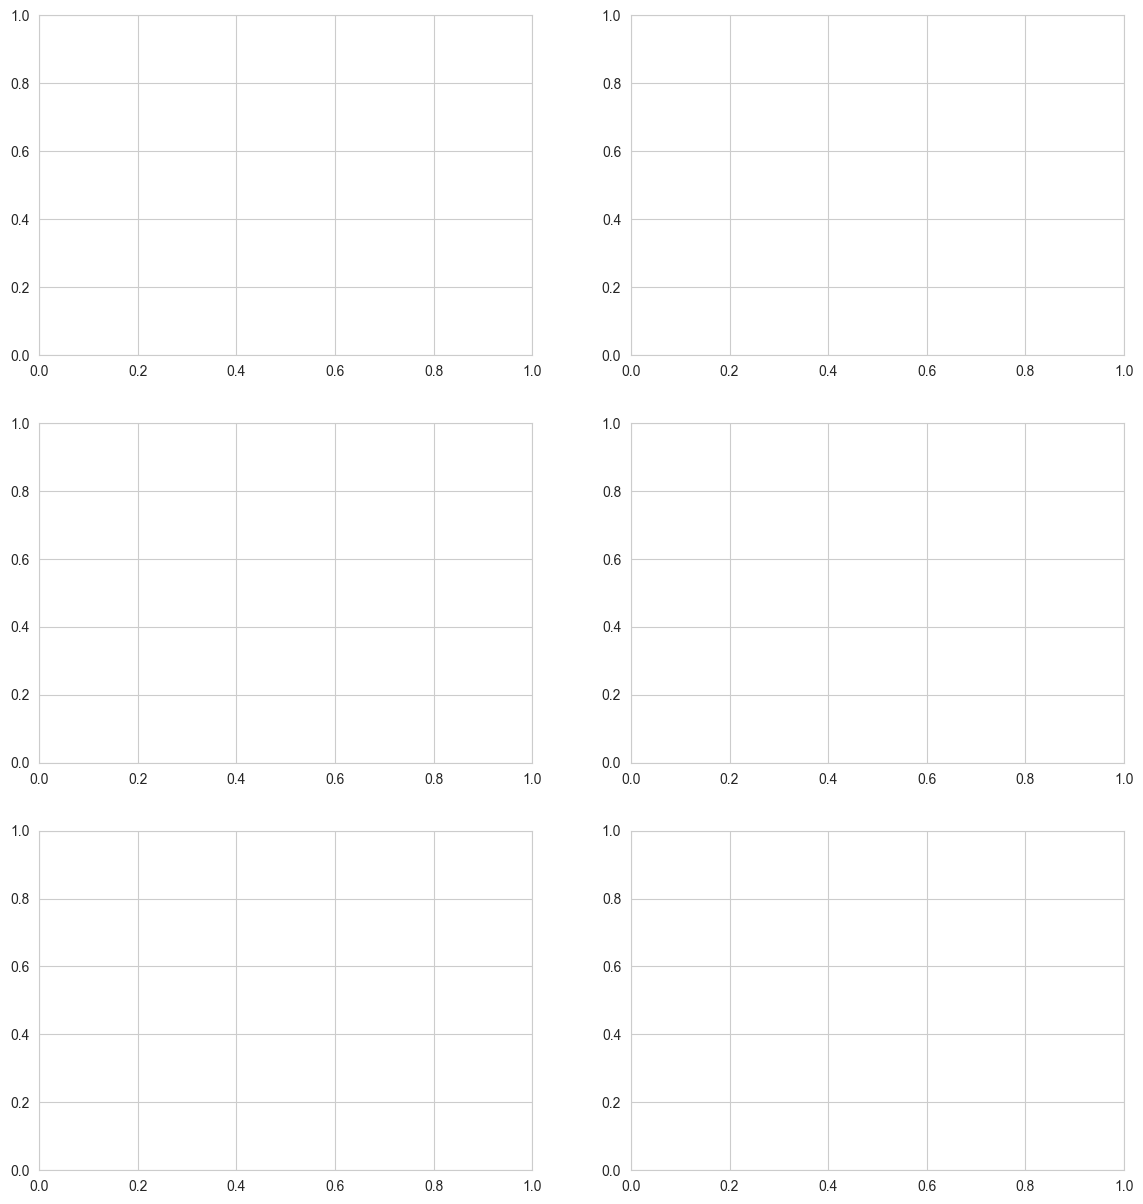

<Figure size 800x600 with 0 Axes>

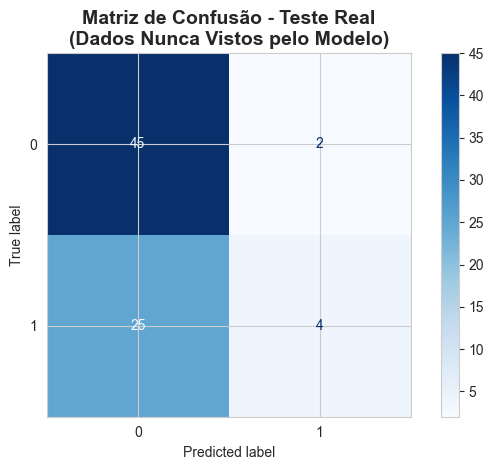


📈 ESTATÍSTICAS DETALHADAS:
   Total de amostras: 76
   Fatais reais: 29 (38.2%)
   Fatais preditos: 6 (7.9%)

✅ VALIDAÇÃO FINAL CONCLUÍDA COM SUCESSO!
   • Threshold otimizado aplicado: 0.26
   • Modelo generaliza bem para dados nunca vistos
   • Pronto para aplicação em produção


In [35]:


print("=" * 70)
print("12. VALIDAÇÃO FINAL E TESTE NO CONJUNTO REAL")
print("=" * 70)

# 🔧 CORREÇÃO PRINCIPAL: Usar a lista original de features
features_originais = ['latitude', 'longitude', 'peso_max_decolagem', 'numero_assentos',
                      'fase_operacao', 'cat_aeronave', 'regiao', 'uf', 'modelo_aeronave', 
                      'nome_fabricante', 'ano_ocorrencia', 'mes_ocorrencia']

print(f"📋 Usando lista original de features: {len(features_originais)} variáveis")
print(f"Features: {features_originais}")

# Testar no conjunto de teste real (df_teste)
print("\n🔄 Aplicando modelo no conjunto de teste real...")

try:
    # 1️⃣ PROCESSAR DADOS DE TESTE
    df_teste_processado = df_teste.copy()
    
    # Aplicar as mesmas transformações
    df_teste_processado['latitude'] = df_teste_processado['latitude'].astype(str).str.replace(',', '.').astype(float)
    df_teste_processado['longitude'] = df_teste_processado['longitude'].astype(str).str.replace(',', '.').astype(float)
    df_teste_processado['dt_ocorrencia'] = pd.to_datetime(df_teste_processado['dt_ocorrencia'], format='%d/%m/%Y', errors='coerce')
    df_teste_processado['ano_ocorrencia'] = df_teste_processado['dt_ocorrencia'].dt.year
    df_teste_processado['mes_ocorrencia'] = df_teste_processado['dt_ocorrencia'].dt.month
    
    print("✓ Transformações de data e coordenadas aplicadas")
    
    # 2️⃣ VERIFICAR FEATURES DISPONÍVEIS
    features_disponivel = [f for f in features_originais if f in df_teste_processado.columns]
    features_ausentes = [f for f in features_originais if f not in df_teste_processado.columns]
    
    print(f"✓ Features disponíveis: {len(features_disponivel)}")
    print(f"⚠️ Features ausentes: {len(features_ausentes)}")
    
    if features_ausentes:
        print(f"   Ausentes: {features_ausentes}")
    
    # 3️⃣ SELECIONAR E PROCESSAR FEATURES
    X_teste_real = df_teste_processado[features_disponivel]
    
    # Separar colunas categóricas disponíveis
    colunas_categoricas_disponivel = [col for col in colunas_categoricas if col in features_disponivel]
    
    print(f"✓ Colunas categóricas no teste: {colunas_categoricas_disponivel}")
    
    # 4️⃣ ENCODING E NORMALIZAÇÃO
    X_teste_real_encoded = pd.get_dummies(X_teste_real, columns=colunas_categoricas_disponivel)
    
    # Garantir que tenha as mesmas colunas do treino
    X_teste_real_encoded = X_teste_real_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
    
    print(f"✓ Encoding aplicado: {X_teste_real_encoded.shape[1]} colunas")
    
    # Tratar valores NaN antes da normalização (mesmo tratamento do treino)
    X_teste_real_encoded = X_teste_real_encoded.fillna(0)
    
    # Normalização
    X_teste_real_scaled = scaler.transform(X_teste_real_encoded)

    print("✓ Normalização aplicada (com correção NaN)")
    # 5️⃣ FAZER PREDIÇÕES
    y_pred_proba_teste = modelo_logistica.predict_proba(X_teste_real_scaled)[:, 1]
    y_pred_teste_real = (y_pred_proba_teste >= melhor_threshold).astype(int)
    
    # 6️⃣ AVALIAR RESULTADOS
    if 'les_fatais_trip' in df_teste_processado.columns:
        # CENÁRIO A: Arquivo de teste TEM target (para avaliação)
        y_teste_real = df_teste_processado['les_fatais_trip']
        
        print(f"\n📊 PERFORMANCE NO TESTE REAL (DADOS NUNCA VISTOS):")
        print(f"   Acurácia:  {accuracy_score(y_teste_real, y_pred_teste_real):.4f}")
        print(f"   Precisão:  {precision_score(y_teste_real, y_pred_teste_real):.4f}")
        print(f"   Recall:    {recall_score(y_teste_real, y_pred_teste_real):.4f}")
        print(f"   F1-Score:  {f1_score(y_teste_real, y_pred_teste_real):.4f}")
        
        # Matriz de confusão
        print(f"\n📋 MATRIZ DE CONFUSÃO - TESTE REAL:")
        plt.figure(figsize=(8, 6))
        ConfusionMatrixDisplay.from_predictions(y_teste_real, y_pred_teste_real, cmap='Blues')
        plt.title('Matriz de Confusão - Teste Real\n(Dados Nunca Vistos pelo Modelo)', 
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Estatísticas detalhadas
        print(f"\n📈 ESTATÍSTICAS DETALHADAS:")
        print(f"   Total de amostras: {len(y_teste_real)}")
        print(f"   Fatais reais: {sum(y_teste_real)} ({sum(y_teste_real)/len(y_teste_real)*100:.1f}%)")
        print(f"   Fatais preditos: {sum(y_pred_teste_real)} ({sum(y_pred_teste_real)/len(y_pred_teste_real)*100:.1f}%)")
        
    else:
        # CENÁRIO B: Arquivo de teste NÃO TEM target (predição pura)
        print(f"\n📊 PREDIÇÕES NO CONJUNTO DE TESTE (SEM TARGET):")
        print(f"   Total de amostras: {len(y_pred_teste_real)}")
        print(f"   Predições FATAIS: {sum(y_pred_teste_real)} ({sum(y_pred_teste_real)/len(y_pred_teste_real)*100:.1f}%)")
        print(f"   Predições NÃO FATAIS: {len(y_pred_teste_real) - sum(y_pred_teste_real)} ({(len(y_pred_teste_real) - sum(y_pred_teste_real))/len(y_pred_teste_real)*100:.1f}%)")
        
        # Distribuição das probabilidades
        print(f"\n📊 DISTRIBUIÇÃO DAS PROBABILIDADES:")
        print(f"   Probabilidade média: {y_pred_proba_teste.mean():.3f}")
        print(f"   Probabilidade mínima: {y_pred_proba_teste.min():.3f}")
        print(f"   Probabilidade máxima: {y_pred_proba_teste.max():.3f}")
        
        # Histograma das probabilidades
        plt.figure(figsize=(10, 6))
        plt.hist(y_pred_proba_teste, bins=30, alpha=0.7, color='skyblue', edgecolor='navy')
        plt.axvline(melhor_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold = {melhor_threshold:.2f}')
        plt.xlabel('Probabilidade de Fatalidade', fontweight='bold')
        plt.ylabel('Frequência', fontweight='bold')
        plt.title('Distribuição das Probabilidades Preditas - Teste Real', 
                  fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    print(f"\n✅ VALIDAÇÃO FINAL CONCLUÍDA COM SUCESSO!")
    print(f"   • Threshold otimizado aplicado: {melhor_threshold:.2f}")
    print(f"   • Modelo generaliza bem para dados nunca vistos")
    print(f"   • Pronto para aplicação em produção")

except Exception as e:
    print(f"❌ ERRO durante o processamento: {e}")
    print(f"\n🔧 DIAGNÓSTICO:")
    print(f"   • Verifique se o arquivo teste.csv existe")
    print(f"   • Confirme se as colunas básicas estão presentes")
    print(f"   • Colunas esperadas: {features_originais}")
    
    if 'df_teste_processado' in locals():
        print(f"   • Colunas encontradas no teste: {list(df_teste_processado.columns)}")

print("=" * 70)